In [1]:
from collegebaseball import ncaa_scraper as ncaa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

/Users/bennettbernard/opt/anaconda3/envs/env2/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Pull Batting Data

In [3]:
teams = pd.read_csv('baseballteams.csv')[['ncaa_name', 'bd_name', 'school_id', 'division']].query("division == 1")

In [4]:
teams

,ncaa_name,bd_name,school_id,division
0,Abilene Christian,Abilene Christian,2,1
1,Air Force,Air Force,721,1
2,Akron,Akron,5,1
3,Alabama,Alabama,8,1
4,Alabama A&M,Alabama A&M,6,1
...,...,...,...,...
305,Bellarmine,NaN,52,1
306,UC San Diego,NaN,112,1
307,Purdue Fort Wayne,NaN,308,1
308,Merrimack,NaN,410,1


In [4]:
batting_games = pd.DataFrame()
errors_team = []
for x,team in enumerate(teams.school_id.unique()):
    if x%30 == 0:
        print(x)
    else: pass
        
    
    try:
        batting_games = pd.concat([batting_games,ncaa.ncaa_team_game_logs(int(team), 2023, 'batting').assign(team = team)])
    except:
        errors_team.append(team)

0
30
60
90
120
150
180
210
240
270
300


In [5]:
errors_team


batting_games2 = pd.DataFrame()
errors_team2 = []
for team in errors_team:
    try:
        batting_games2 = pd.concat([batting_games2,ncaa.ncaa_team_game_logs(int(team), 2023, 'batting').assign(team = team)])
    except:
        errors_team2.append(team)


In [6]:
errors_team2

batting_games3 = pd.DataFrame()
errors_team3 = []
for team in errors_team2:
    try:
        batting_games3 = pd.concat([batting_games3,ncaa.ncaa_team_game_logs(int(team), 2023, 'batting').assign(team = team)])
    except:
        errors_team3.append(team)

# Export Batting Data

In [7]:
pd.concat([batting_games,batting_games2,batting_games3]).to_csv('2023battingdata.csv')

# Import Batting Data

In [2]:
battingdf = pd.read_csv('2023battingdata.csv').drop(columns='Unnamed: 0')#.query("date < '02/20/2023'")

In [3]:

#NOTES:
#HBP and BB are separate
#H includes 1B + ALL other

#TRYING USING PLATE APPEARANCES BUT AT BATS MIGHT BE BETTER
#BB and IBB and HBP impact At Bats, but what effect does that have on the game

#H & BB [OR OBP] can be treated like success rate (not IBB)
# 1B, 2B, 3B and HR can be treated like explosiveness
battingdf['3Br'] = battingdf['3B']/battingdf['AB']
battingdf['2Br'] = (battingdf['2B']+battingdf['3B'])/battingdf['AB']
battingdf['HRr'] = battingdf['HR']/battingdf['AB']

battingdf['BRBI'] = battingdf['RBI']-battingdf['HR']
battingdf['BRs'] = round(battingdf['OBP']*battingdf['PA'],0)-battingdf['HR']
battingdf['BRBIr'] = battingdf['BRBI']/battingdf['BRs']
battingdf['SFr'] = battingdf['SF']/battingdf['PA']
battingdf['SHr'] = battingdf['SH']/battingdf['PA']
battingdf['ROB'] = round(battingdf['OBP']*battingdf['PA'],0)



#COMBINED STATS
#battingdf['test'] = (battingdf['OBP']-(battingdf['HRr'])) * battingdf['BRBIr'] + battingdf['HRr']
#battingdf['test'] = battingdf['OBP'] + battingdf['2Br'] + battingdf['HRr'] #- battingdf['K/PA']
#battingdf['test'] = battingdf['OBP']*2 + battingdf['BRBIr'] + battingdf['HRr']

#battingdf['test'] = (battingdf['2Br'] + battingdf['HRr'])#/(battingdf['OBP']) #+ battingdf['SFr']#Extra Bases and HRs
#battingdf['test'] = battingdf['OBP']*battingdf['OBP']*battingdf['OBP']

#battingdf['test'] = battingdf['OBP']*battingdf['OBP']*battingdf['OBP'] + (battingdf['2Br'] + battingdf['HRr'] + battingdf['SFr'])
#battingdf['test'] = battingdf['K/PA'] - (battingdf['HR']/battingdf['PA'])*3
#battingdf['test'] = battingdf['OB/O']#battingdf['BRBIr']#battingdf['OB/O']

#NEW VERSION OF STATS
battingdf['est_outs'] = battingdf['innings_played']*3
battingdf['OB/O'] = round(battingdf['OBP']*battingdf['PA'],0)/battingdf['est_outs'] #calculate On Base, divide by OUTS
battingdf['Exp'] = (battingdf['2B']+battingdf['3B']+battingdf['HR'])/battingdf['AB']
battingdf['BRBIP'] = battingdf['BRBI']/battingdf['PA']
battingdf['BRBIPO'] = battingdf['BRBI']/battingdf['est_outs']


#BASERUNNING/MOVEMENT
battingdf['BaseRunning'] = (battingdf['CS'] + battingdf['Picked'] - battingdf['SB']+battingdf['SF']+battingdf['SH'])/battingdf['BRs']


In [4]:
battingdf['date'].max()

'06/05/2023'

# Calculate Value Ratings

In [8]:
coefs = {'OB/O': 9.301826221953299,
 'BaseRunning': -1.3832103933038162,
 '2B': 0.3595535604815406,
 '3B': 0.7961030889059585,
 'HR': 0.9500855124014874,
 'HFA': 0.22837677878076784}

#expected = battingdf[battingdf['date'] < '03/01/2022'].copy()
expected = battingdf.copy()

expected['Eff Runs'] = expected['OB/O']*coefs['OB/O']+ expected['BaseRunning']*coefs['BaseRunning']#+ expRuns['BRBIPO']*coefs['BRBIPO']


expected['Expl Runs']= expected['2B']*coefs['2B'] +expected['3B']*coefs['3B'] + expected['HR']*coefs['HR']

expected['Exceeded Runs'] = expected['R'] - (expected['Eff Runs'] + expected['Expl Runs'])


In [9]:
teams

,ncaa_name,bd_name,school_id,division
0,Abilene Christian,Abilene Christian,2,1
1,Air Force,Air Force,721,1
2,Akron,Akron,5,1
3,Alabama,Alabama,8,1
4,Alabama A&M,Alabama A&M,6,1
...,...,...,...,...
305,Bellarmine,NaN,52,1
306,UC San Diego,NaN,112,1
307,Purdue Fort Wayne,NaN,308,1
308,Merrimack,NaN,410,1


In [10]:
expected = expected.merge(teams, how='left', left_on='team',right_on='school_id').rename(columns={'team':'team_id','ncaa_name':'team','school_id_x':'school_id'})


In [11]:
#pd.merge(battingdf,teams,left_on='opponent_id',right_on='school_id').query("game_id == ")#.query("division_y == 1")
#battingdf.columns
expected['date'].max()

'06/05/2023'

## Early Season Evaluations

In [12]:
display(expected.query("(team == 'LSU') | (opponent_name == 'LSU')").sort_values(by='game_id')\
[['game_id', 'R', 'H', '2B', '3B', 'HR', 'BB', 'HBP','Eff Runs', 'Expl Runs', 'Exceeded Runs', 'team','opponent_name']])


,game_id,R,H,2B,3B,HR,BB,HBP,Eff Runs,Expl Runs,Exceeded Runs,team,opponent_name
15739,2390477,0,3,1,0,0,2,0,1.722560,0.359554,-2.082114,Western Mich.,LSU
6747,2390477,10,9,1,1,0,5,2,5.339292,1.155657,3.505051,LSU,Western Mich.
15740,2390721,3,3,0,0,1,3,1,2.181050,0.950086,-0.131135,Western Mich.,LSU
6748,2390721,5,7,1,1,1,6,0,4.716768,2.105742,-1.822511,LSU,Western Mich.
6749,2390997,9,10,2,0,3,7,2,6.372828,3.569364,-0.942192,LSU,Western Mich.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14524,2566954,2,7,0,0,1,0,0,2.411585,0.950086,-1.361670,Tulane,LSU
6806,2566956,6,10,0,1,5,4,2,5.512193,5.546531,-5.058724,LSU,Oregon St.
10595,2566956,5,13,3,0,3,5,0,5.924575,3.928917,-4.853493,Oregon St.,LSU
10597,2566959,7,8,1,0,3,4,3,5.052414,3.209810,-1.262224,Oregon St.,LSU


In [13]:
#display(expected.query("team == 'Liberty'"))
#display(expected.query("(team == 'Texas A&M') | (opponent_name == 'Texas A&M')").sort_values(by='game_id')\
#[['game_id', 'R', 'H', '2B', '3B', 'HR', 'BB', 'HBP','Eff Runs', 'Expl Runs', 'Exceeded Runs', 'team','opponent_name']])

display(HTML("<h2>Runs</h2>"))
display(HTML(expected.groupby(by='team', as_index=False).mean()[['team','R', 'Eff Runs', 'Expl Runs']]\
.sort_values(by='R', ascending=False).head(5).rename(columns={'team':'Hitting'}).to_html(index=False)))

display(HTML("<h2>Expected Efficient Runs</h2>"))
display(HTML(expected.groupby(by='team', as_index=False).mean()[['team','R', 'Eff Runs', 'Expl Runs']]\
.sort_values(by='Eff Runs', ascending=False).head(5).rename(columns={'team':'Hitting'}).to_html(index=False)))

display(HTML("<h2>Expected Explosive Runs</h2>"))
display(HTML(expected.groupby(by='team', as_index=False).mean()[['team','R', 'Eff Runs', 'Expl Runs']]\
.sort_values(by='Expl Runs', ascending=False).head(5).rename(columns={'team':'Hitting'}).to_html(index=False)))


display(HTML("<h2>Runs Allowed</h2>"))
display(HTML(expected.groupby(by='opponent_name', as_index=False).mean()[['opponent_name','R', 'Eff Runs', 'Expl Runs']]\
.sort_values(by='R', ascending=True).head(5).rename(columns={'team':'Pitching'}).to_html(index=False)))

display(HTML("<h2>Expected Efficient Runs Allowed</h2>"))
display(HTML(expected.groupby(by='opponent_name', as_index=False).mean()[['opponent_name','R', 'Eff Runs', 'Expl Runs']]\
.sort_values(by='Eff Runs', ascending=True).head(5).rename(columns={'team':'Pitching'}).to_html(index=False)))

display(HTML("<h2>Expected Explosive Runs Allowed</h2>"))
display(HTML(expected.groupby(by='opponent_name', as_index=False).mean()[['opponent_name','R', 'Eff Runs', 'Expl Runs']]\
.sort_values(by='Expl Runs', ascending=True).head(5).rename(columns={'team':'Pitching'}).to_html(index=False)))


Hitting,R,Eff Runs,Expl Runs
FGCU,9.633333,6.382813,3.129006
Campbell,9.622951,6.714232,2.884927
Fairfield,9.436364,6.250999,2.635181
LSU,9.278689,6.342397,2.800716
Wake Forest,9.266667,6.389917,2.694615


Hitting,R,Eff Runs,Expl Runs
Campbell,9.622951,6.714232,2.884927
Wake Forest,9.266667,6.389917,2.694615
FGCU,9.633333,6.382813,3.129006
Maryland,9.174603,6.371515,2.944565
Savannah St.,8.638298,6.352877,1.161094


Hitting,R,Eff Runs,Expl Runs
FGCU,9.633333,6.382813,3.129006
Maryland,9.174603,6.371515,2.944565
Arizona,8.457627,5.821606,2.889626
Campbell,9.622951,6.714232,2.884927
New Mexico,8.647059,5.887206,2.876630


opponent_name,R,Eff Runs,Expl Runs
Barton,0.0,3.306800,0.359554
Embry-Riddle (FL),1.0,4.478657,0.000000
La. Christian,3.0,4.625568,0.719107
Benedictine Mesa,3.0,2.756097,0.950086
Wake Forest,3.3,3.474339,1.262995


opponent_name,R,Eff Runs,Expl Runs
Saginaw Valley,4.0,2.558495,1.309639
Benedictine Mesa,3.0,2.756097,0.950086
Barton,0.0,3.306800,0.359554
Wake Forest,3.3,3.474339,1.262995
St. Xavier,5.0,3.620603,0.719107


opponent_name,R,Eff Runs,Expl Runs
Embry-Riddle (FL),1.0,4.478657,0.000000
MSOE,6.0,4.710483,0.000000
Lake Erie,7.0,6.182167,0.359554
Voorhees,9.0,7.923778,0.359554
Coe,8.0,7.097723,0.359554


In [84]:
def powerrank(df1):

    #First Iteration
    dfz = df1[['school_id','opponent_id','Eff Runs', 'Expl Runs','Exceeded Runs']].copy()
    dfz['Eff_Havg'] = dfz['Eff Runs'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl Runs'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff Runs'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl Runs'].groupby(by=dfz['opponent_id']).transform('mean')

    dfz['Eff_HV_1'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_1'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_1'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_1'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247

    dfz

    #Second Iteration = uses the fist iterations adjusted numbers
    #Take averages to create team averages
    dfz = dfz.drop(columns={'Exceeded Runs' ,'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after First Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_1'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_1'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_1'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_1'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 2nd Iteration
    dfz['Eff_HV_2'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_2'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_2'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_2'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247



    #Third Iteration = use 2nd iterations adjusted numbers
    dfz = dfz.drop(columns={'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after 2nd Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_2'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_2'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_2'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_2'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 3rd Iteration
    dfz['Eff_HV_3'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_3'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_3'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_3'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247


    #Fourth Iteration = use 3rd iterations adjusted numbers
    dfz = dfz.drop(columns={'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after 3rd Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_3'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_3'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_3'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_3'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 4th Iteration
    dfz['Eff_HV_4'] = dfz['Eff Runs'] - dfz['Eff_Pavg']
    dfz['Expl_HV_4'] = dfz['Expl Runs'] - dfz['Expl_Pavg']

    dfz['Eff_PV_4'] = dfz['Eff Runs'] - dfz['Eff_Havg']
    dfz['Expl_PV_4'] = dfz['Expl Runs'] - dfz['Expl_Havg']


    dfz
    #Group by Eff/Expl_XX_4 to get the "True" Team values

    rankhit = dfz[['school_id', 'Eff_HV_4', 'Expl_HV_4']].groupby(by='school_id', as_index=False).mean().assign(HV = lambda x: x['Eff_HV_4']+x['Expl_HV_4']).sort_values(by='HV',ascending=False)
    rankpitch = dfz[['opponent_id', 'Eff_PV_4', 'Expl_PV_4']].groupby(by='opponent_id',as_index=False).mean().assign(PV = lambda x: x['Eff_PV_4']+x['Expl_PV_4']).sort_values(by='PV',ascending=True)

    #dfz[['team', 'opponent_name', 'Eff_HV_4', 'Expl_HV_4','Eff_PV_4', 'Expl_PV_4']]

    #ADD IN TEAMID


    power4 = pd.merge(rankhit,rankpitch, how='left',left_on='school_id',right_on='opponent_id').assign(Value = lambda x: round(x['HV']-x['PV'],2)).sort_values(by='Value',ascending=False)
    power4['Ranking'] = power4['Value'].rank(ascending=False).astype(int, errors='ignore')
    power4['Eff_HV Rank'] = power4['Eff_HV_4'].rank(ascending=False)
    power4['Expl_HV Rank'] = power4['Expl_HV_4'].rank(ascending=False)
    power4['HV Rank'] = power4['HV'].rank(ascending=False)

    power4['Eff_PV Rank'] = power4['Eff_PV_4'].rank(ascending=True)
    power4['Expl_PV Rank'] = power4['Expl_PV_4'].rank(ascending=True)
    power4['PV Rank'] = power4['PV'].rank(ascending=True)

    power4 = teams[['ncaa_name', 'school_id']].merge(power4, how='right',on='school_id')
    #[power4['opponent_id'].isna()]#.query(f"opponent_name == {np.nan}")
    power4.query("Value >2")#.head(20)
    return power4

powerrank(expected.query("date < '05/20/2023'")).head(20)

,ncaa_name,school_id,Eff_HV_4,Expl_HV_4,HV,opponent_id,Eff_PV_4,Expl_PV_4,PV,Value,Ranking,Eff_HV Rank,Expl_HV Rank,HV Rank,Eff_PV Rank,Expl_PV Rank,PV Rank
0,Wake Forest,749,1.484561,1.032512,2.517073,749.0,-2.171404,-0.851550,-3.022955,5.54,1.0,6.0,16.0,7.0,1.0,1.0,1.0
1,LSU,365,1.760760,1.333359,3.094118,365.0,-1.468996,-0.673902,-2.142898,5.24,2.0,2.0,3.0,2.0,5.0,6.0,4.0
2,Tennessee,694,1.060945,1.202620,2.263565,694.0,-1.818962,-0.344761,-2.163723,4.43,3.0,27.0,8.0,14.0,2.0,35.0,3.0
3,Alabama,8,1.065156,0.844978,1.910135,8.0,-1.654202,-0.727590,-2.381791,4.29,4.0,26.0,26.0,22.0,3.0,4.0,2.0
4,South Carolina,648,1.373335,1.120963,2.494298,648.0,-1.342363,-0.441693,-1.784056,4.28,5.0,11.0,11.0,9.0,8.0,24.0,9.0
5,Virginia,746,1.487200,0.691276,2.178476,746.0,-1.373653,-0.445264,-1.818917,4.00,6.0,5.0,37.0,15.0,6.0,23.0,8.0
6,Duke,193,1.129978,0.988185,2.118163,193.0,-1.259595,-0.609021,-1.868616,3.99,7.0,23.0,19.0,17.0,9.0,8.0,7.0
7,Campbell,115,1.833742,1.266932,3.100674,115.0,-0.424471,-0.358385,-0.782857,3.88,8.0,1.0,6.0,1.0,76.0,33.0,59.0
8,Florida,235,1.041221,1.346948,2.388168,235.0,-0.949951,-0.493829,-1.443780,3.83,9.0,29.0,2.0,10.0,29.0,16.0,17.0
9,Kentucky,334,1.520439,0.256168,1.776607,334.0,-1.170863,-0.836381,-2.007243,3.78,10.0,4.0,115.0,26.0,12.0,2.0,6.0


# *Test Using Trim Means

In [105]:
#expected.query("team=='LSU'")['Eff Runs'].plot(kind='hist')

#expected.query("team=='LSU'")['Eff Runs'].mean()

#display(np.mean([abs(x-expected.query("team=='LSU'")['Eff Runs'].mean()) for x in list(expected.query("team=='LSU'")['Eff Runs'])]))
#display(np.mean([abs(x-expected.query("team=='LSU'")['Eff Runs'].quantile(.4)) for x in list(expected.query("team=='LSU'")['Eff Runs'])]))


#Minimize the "miss" from the "average" for the maximum number of games
display(expected.query("team=='LSU'")['Eff Runs'].quantile(.75))
display(expected.query("team=='LSU'")['Eff Runs'].quantile(.5))
display(expected.query("team=='LSU'")['Eff Runs'].quantile(.25))
expected.query("team=='LSU'")['Eff Runs'].mean()


7.161953181169908

6.372828264433789

5.413392574334221

6.342396935595511

# Calculate MOMENTUM Ratings

In [15]:
def momrank(df1):

    #First Iteration
    dfz = df1[['date','school_id','opponent_id','Eff Runs', 'Expl Runs','Exceeded Runs']].copy()
    dfz['Eff_Havg'] = dfz['Eff Runs'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl Runs'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff Runs'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl Runs'].groupby(by=dfz['opponent_id']).transform('mean')

    dfz['Eff_HV_1'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_1'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_1'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_1'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247

    dfz

    #Second Iteration = uses the fist iterations adjusted numbers
    #Take averages to create team averages
    dfz = dfz.drop(columns={'Exceeded Runs' ,'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after First Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_1'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_1'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_1'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_1'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 2nd Iteration
    dfz['Eff_HV_2'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_2'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_2'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_2'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247



    #Third Iteration = use 2nd iterations adjusted numbers
    dfz = dfz.drop(columns={'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after 2nd Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_2'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_2'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_2'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_2'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 3rd Iteration
    dfz['Eff_HV_3'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_3'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_3'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_3'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247


    #Fourth Iteration = use 3rd iterations adjusted numbers
    dfz = dfz.drop(columns={'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after 3rd Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_3'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_3'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_3'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_3'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 4th Iteration
    dfz['Eff_HV_4'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_4'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_4'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_4'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247


    dfz
    #Group by Eff/Expl_XX_4 to get the "True" Team values
#*********MOMENTUM******!!!!!!!!!!!!!!!!!!!!!!!!!LIMIT TO LAST 10 GAMES!!!!!!!!!!!!!!
    rankhit = dfz.sort_values(by='date', ascending=True)[['school_id', 'Eff_HV_4', 'Expl_HV_4']].groupby(by='school_id', as_index=False).tail(10).groupby(by='school_id',as_index=False).mean().assign(HV = lambda x: x['Eff_HV_4']+x['Expl_HV_4']).sort_values(by='HV',ascending=False)
    rankpitch = dfz.sort_values(by='date', ascending=True)[['opponent_id', 'Eff_PV_4', 'Expl_PV_4']].groupby(by='opponent_id',as_index=False).tail(10).groupby(by='opponent_id',as_index=False).mean().assign(PV = lambda x: x['Eff_PV_4']+x['Expl_PV_4']).sort_values(by='PV',ascending=True)
    
    display(dfz.query("school_id == 490").tail(10))
    #dfz[['team', 'opponent_name', 'Eff_HV_4', 'Expl_HV_4','Eff_PV_4', 'Expl_PV_4']]

    #ADD IN TEAMID


    power4 = pd.merge(rankhit,rankpitch, how='left',left_on='school_id',right_on='opponent_id').assign(Value = lambda x: round(x['HV']-x['PV'],2)).sort_values(by='Value',ascending=False)
    power4['Ranking'] = power4['Value'].rank(ascending=False).astype(int, errors='ignore')
    power4['Eff_HV Rank'] = power4['Eff_HV_4'].rank(ascending=False)
    power4['Expl_HV Rank'] = power4['Expl_HV_4'].rank(ascending=False)
    power4['HV Rank'] = power4['HV'].rank(ascending=False)

    power4['Eff_PV Rank'] = power4['Eff_PV_4'].rank(ascending=True)
    power4['Expl_PV Rank'] = power4['Expl_PV_4'].rank(ascending=True)
    power4['PV Rank'] = power4['PV'].rank(ascending=True)

    power4 = teams[['ncaa_name', 'school_id']].merge(power4, how='right',on='school_id')
    #[power4['opponent_id'].isna()]#.query(f"opponent_name == {np.nan}")
    power4.query("Value >2")#.head(20)
    return power4

momrank(expected)[['ncaa_name', 'school_id', 'HV','HV Rank', 'PV','PV Rank', 'Value', 'Ranking']].head(20)#.query("ncaa_name == 'Southern Miss.'")#.head(30)


,date,school_id,opponent_id,Eff Runs,Expl Runs,Eff_HV_1,Expl_HV_1,Eff_PV_1,Expl_PV_1,Eff_HV_2,...,Eff_PV_3,Expl_PV_3,Eff_Havg,Expl_Havg,Eff_Pavg,Expl_Pavg,Eff_HV_4,Expl_HV_4,Eff_PV_4,Expl_PV_4
9351,05/12/2023,490,457,1.261490,1.900171,1.772275,1.772507,0.804062,1.218553,2.197353,...,0.345927,1.019253,6.000206,2.593478,3.945267,1.488525,2.439031,2.216893,0.384092,1.111940
9352,05/13/2023,490,457,2.756097,2.259725,3.266882,2.132060,2.298669,1.578107,3.691960,...,1.840534,1.378807,6.000206,2.593478,3.945267,1.488525,3.933638,2.576447,1.878699,1.471493
9353,05/18/2023,490,545,6.201217,2.388300,5.369365,2.026186,5.743789,1.706682,5.745775,...,5.285655,1.507382,6.000206,2.593478,5.411420,1.638018,5.912606,2.555529,5.323819,1.600068
9354,05/19/2023,490,545,8.148011,2.824849,7.316158,2.462735,7.690583,2.143231,7.692569,...,7.232448,1.943931,6.000206,2.593478,5.411420,1.638018,7.859399,2.992078,7.270613,2.036618
9355,05/20/2023,490,545,4.324967,4.159896,3.493114,3.797781,3.867539,3.478278,3.869525,...,3.409404,3.278978,6.000206,2.593478,5.411420,1.638018,4.036355,4.327125,3.447569,3.371664
9356,05/23/2023,490,193,5.155089,1.669193,5.828270,1.891696,4.697661,0.987575,6.293357,...,4.239526,0.788275,6.000206,2.593478,3.763052,1.127419,6.514845,2.347020,4.277691,0.880961
9357,05/25/2023,490,415,4.478657,0.000000,5.101159,-0.196529,4.021229,-0.681618,5.425583,...,3.563094,-0.880918,6.000206,2.593478,3.915323,1.520138,5.686142,0.285109,3.601259,-0.788231
9358,06/02/2023,490,115,4.823169,3.928917,5.208172,4.331440,4.365741,3.247299,5.284990,...,3.907606,3.047999,6.000206,2.593478,4.610445,1.339527,5.335532,4.394637,3.945771,3.140686
9359,06/03/2023,490,648,4.134145,0.719107,5.061262,0.949323,3.676717,0.037489,5.318441,...,3.218582,-0.161811,6.000206,2.593478,3.661736,1.183297,5.595217,1.341057,3.256747,-0.069124
9360,06/04/2023,490,115,5.775340,0.000000,6.160343,0.402523,5.317912,-0.681618,6.237161,...,4.859777,-0.880918,6.000206,2.593478,4.610445,1.339527,6.287703,0.465720,4.897942,-0.788231


,ncaa_name,school_id,HV,HV Rank,PV,PV Rank,Value,Ranking
0,TCU,698,10.494078,3.0,4.880742,15.0,5.61,1.0
1,Wake Forest,749,10.124519,5.0,4.589223,9.0,5.54,2.0
2,Virginia,746,9.141784,21.0,3.774073,1.0,5.37,3.0
3,DBU,1045,9.849289,10.0,4.622499,11.0,5.23,4.0
4,Auburn,37,9.379227,17.0,4.165893,3.0,5.21,5.0
5,LSU,365,10.103521,6.0,5.068964,20.0,5.03,6.0
6,Texas,703,9.542092,15.0,4.685933,12.0,4.86,7.0
7,Miami (FL),415,9.758742,11.0,4.988369,19.0,4.77,8.0
8,Southern Miss.,664,8.481520,43.0,3.968313,2.0,4.51,9.0
9,Clemson,147,9.683300,12.0,5.249545,24.0,4.43,10.0


# CONSISTENCY Ratings

In [16]:
def conrank(df1):

    #First Iteration
    dfz = df1[['date','school_id','opponent_id','Eff Runs', 'Expl Runs','Exceeded Runs']].copy()
    dfz['Eff_Havg'] = dfz['Eff Runs'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl Runs'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff Runs'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl Runs'].groupby(by=dfz['opponent_id']).transform('mean')

    dfz['Eff_HV_1'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_1'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_1'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_1'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247

    dfz

    #Second Iteration = uses the fist iterations adjusted numbers
    #Take averages to create team averages
    dfz = dfz.drop(columns={'Exceeded Runs' ,'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after First Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_1'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_1'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_1'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_1'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 2nd Iteration
    dfz['Eff_HV_2'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_2'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_2'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_2'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247



    #Third Iteration = use 2nd iterations adjusted numbers
    dfz = dfz.drop(columns={'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after 2nd Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_2'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_2'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_2'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_2'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 3rd Iteration
    dfz['Eff_HV_3'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_3'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_3'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_3'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247


    #Fourth Iteration = use 3rd iterations adjusted numbers
    dfz = dfz.drop(columns={'Eff_Havg', 'Expl_Havg','Eff_Pavg', 'Expl_Pavg'})#.rename(columns={'Eff_HV_1':'Eff_Havg','Expl_HV_1':'Expl_Havg','Eff_PV_1':'Eff_Pavg','Expl_PV_1':'Expl_Pavg'})

    #Calculate Averages after 3rd Iteration
    dfz['Eff_Havg'] = dfz['Eff_HV_3'].groupby(by=dfz['school_id']).transform('mean')
    dfz['Expl_Havg'] = dfz['Expl_HV_3'].groupby(by=dfz['school_id']).transform('mean')

    dfz['Eff_Pavg'] = dfz['Eff_PV_3'].groupby(by=dfz['opponent_id']).transform('mean')
    dfz['Expl_Pavg'] = dfz['Expl_PV_3'].groupby(by=dfz['opponent_id']).transform('mean')

    #Calculate 4th Iteration
    dfz['Eff_HV_4'] = dfz['Eff Runs'] - dfz['Eff_Pavg'] + 5.122808
    dfz['Expl_HV_4'] = dfz['Expl Runs'] - dfz['Expl_Pavg'] + 1.805247

    dfz['Eff_PV_4'] = dfz['Eff Runs'] - dfz['Eff_Havg'] + 5.122808
    dfz['Expl_PV_4'] = dfz['Expl Runs'] - dfz['Expl_Havg'] + 1.805247


    dfz
    #Group by Eff/Expl_XX_4 to get the "True" Team values
#*********CONSISTENCY******!!!!!!!!!!!!!!!!!!!!!!!!!LIMIT TO LAST 10 GAMES!!!!!!!!!!!!!!
    rankhit = dfz.sort_values(by='date', ascending=True)[['school_id', 'Eff_HV_4', 'Expl_HV_4']].groupby(by='school_id', as_index=False).tail(100).groupby(by='school_id',as_index=False).std().assign(HV = lambda x: x['Eff_HV_4']+x['Expl_HV_4']).sort_values(by='HV',ascending=False)
    rankpitch = dfz.sort_values(by='date', ascending=True)[['opponent_id', 'Eff_PV_4', 'Expl_PV_4']].groupby(by='opponent_id',as_index=False).tail(100).groupby(by='opponent_id',as_index=False).std().assign(PV = lambda x: x['Eff_PV_4']+x['Expl_PV_4']).sort_values(by='PV',ascending=True)
    
    display(dfz.query("school_id == 490").tail(10))
    #dfz[['team', 'opponent_name', 'Eff_HV_4', 'Expl_HV_4','Eff_PV_4', 'Expl_PV_4']]

    #ADD IN TEAMID


    power4 = pd.merge(rankhit,rankpitch, how='left',left_on='school_id',right_on='opponent_id').assign(Value = lambda x: round(x['HV']+x['PV'],2)).sort_values(by='Value',ascending=True)
    power4['Ranking'] = power4['Value'].rank(ascending=False).astype(int, errors='ignore')
    power4['Eff_HV Rank'] = power4['Eff_HV_4'].rank(ascending=False)
    power4['Expl_HV Rank'] = power4['Expl_HV_4'].rank(ascending=False)
    power4['HV Rank'] = power4['HV'].rank(ascending=False)

    power4['Eff_PV Rank'] = power4['Eff_PV_4'].rank(ascending=True)
    power4['Expl_PV Rank'] = power4['Expl_PV_4'].rank(ascending=True)
    power4['PV Rank'] = power4['PV'].rank(ascending=True)

    power4 = teams[['ncaa_name', 'school_id']].merge(power4, how='right',on='school_id')
    #[power4['opponent_id'].isna()]#.query(f"opponent_name == {np.nan}")
    #power4.query("Value >2")#.head(20)
    return power4

conrank(expected)[['ncaa_name', 'school_id', 'HV','HV Rank', 'PV','PV Rank', 'Value', 'Ranking']].head(20)#.query("ncaa_name == 'Southern Miss.'")#.head(30)


,date,school_id,opponent_id,Eff Runs,Expl Runs,Eff_HV_1,Expl_HV_1,Eff_PV_1,Expl_PV_1,Eff_HV_2,...,Eff_PV_3,Expl_PV_3,Eff_Havg,Expl_Havg,Eff_Pavg,Expl_Pavg,Eff_HV_4,Expl_HV_4,Eff_PV_4,Expl_PV_4
9351,05/12/2023,490,457,1.261490,1.900171,1.772275,1.772507,0.804062,1.218553,2.197353,...,0.345927,1.019253,6.000206,2.593478,3.945267,1.488525,2.439031,2.216893,0.384092,1.111940
9352,05/13/2023,490,457,2.756097,2.259725,3.266882,2.132060,2.298669,1.578107,3.691960,...,1.840534,1.378807,6.000206,2.593478,3.945267,1.488525,3.933638,2.576447,1.878699,1.471493
9353,05/18/2023,490,545,6.201217,2.388300,5.369365,2.026186,5.743789,1.706682,5.745775,...,5.285655,1.507382,6.000206,2.593478,5.411420,1.638018,5.912606,2.555529,5.323819,1.600068
9354,05/19/2023,490,545,8.148011,2.824849,7.316158,2.462735,7.690583,2.143231,7.692569,...,7.232448,1.943931,6.000206,2.593478,5.411420,1.638018,7.859399,2.992078,7.270613,2.036618
9355,05/20/2023,490,545,4.324967,4.159896,3.493114,3.797781,3.867539,3.478278,3.869525,...,3.409404,3.278978,6.000206,2.593478,5.411420,1.638018,4.036355,4.327125,3.447569,3.371664
9356,05/23/2023,490,193,5.155089,1.669193,5.828270,1.891696,4.697661,0.987575,6.293357,...,4.239526,0.788275,6.000206,2.593478,3.763052,1.127419,6.514845,2.347020,4.277691,0.880961
9357,05/25/2023,490,415,4.478657,0.000000,5.101159,-0.196529,4.021229,-0.681618,5.425583,...,3.563094,-0.880918,6.000206,2.593478,3.915323,1.520138,5.686142,0.285109,3.601259,-0.788231
9358,06/02/2023,490,115,4.823169,3.928917,5.208172,4.331440,4.365741,3.247299,5.284990,...,3.907606,3.047999,6.000206,2.593478,4.610445,1.339527,5.335532,4.394637,3.945771,3.140686
9359,06/03/2023,490,648,4.134145,0.719107,5.061262,0.949323,3.676717,0.037489,5.318441,...,3.218582,-0.161811,6.000206,2.593478,3.661736,1.183297,5.595217,1.341057,3.256747,-0.069124
9360,06/04/2023,490,115,5.775340,0.000000,6.160343,0.402523,5.317912,-0.681618,6.237161,...,4.859777,-0.880918,6.000206,2.593478,4.610445,1.339527,6.287703,0.465720,4.897942,-0.788231


,ncaa_name,school_id,HV,HV Rank,PV,PV Rank,Value,Ranking
0,Milwaukee,797,2.429335,291.0,2.606008,12.0,5.04,300.0
1,Winthrop,792,2.270475,298.0,2.847701,72.0,5.12,299.0
2,UAB,9,2.180741,301.0,3.052281,139.0,5.23,298.0
3,Southern Ill.,659,2.713121,260.0,2.583966,9.0,5.30,297.0
4,UC Davis,108,2.503519,288.0,2.865823,83.0,5.37,296.0
5,Hartford,272,2.237707,299.0,3.153955,165.0,5.39,294.0
6,Houston Baptist,287,2.708679,262.0,2.681422,24.0,5.39,294.0
7,Lamar University,346,2.668826,266.0,2.724123,36.0,5.39,294.0
8,Nicholls St.,483,2.717618,258.0,2.743379,39.0,5.46,291.5
9,Jacksonville,316,2.581728,280.0,2.874884,85.0,5.46,291.5


# Calculate SOR Ratings

In [17]:
from statsmodels.iolib.smpickle import load_pickle
results_sor = load_pickle("sor_2022.pickle")

In [18]:
results_sor.predict(1)

array([0.62463461])

In [19]:
def sorrank(df2):
    allgames = df2[['date', 'field', 'season_id', 'opponent_id', 'opponent_name','team','school_id','runs_scored','runs_allowed','result', 'game_id']].copy()
    allgames.loc[allgames['result']=='win', 'Win'] = 1
    allgames.loc[allgames['result']=='loss', 'Win'] = 0

    #WE NEED TO ADD THE DATE FILTER HERE TOO!!!
    allgames = pd.merge(allgames,powerrank(df2)[['Ranking', 'Value','school_id']],how='left',
             left_on='opponent_id', right_on='school_id')
    #allgames = allgames.merge(power4[['school_id','team']], how='left',left_on='school_id_x',right_on='school_id')

    allgames = allgames.assign(sos_value = lambda x: np.where(x['field']=='home', -.2283+x['Value'],np.where(x['field']=='away', .2283+x['Value'],0+x['Value'])))\
    .assign(baseline = lambda x: 2-x['sos_value'])
    
    sordf = pd.concat([allgames,results_sor.predict(allgames['baseline'])], axis=1).rename(columns={0: 'pred'})\
    .assign(sor = lambda x: x['Win']-x['pred'])\
    .groupby(by='team', as_index=False).mean().sort_values(by='sor', ascending=False)
    #.assign(sor_ratio = lambda x: x['Win']/x['pred']).head(40)

    sordf['sor_rank'] = sordf['sor'].rank(ascending=False)
    
    return sordf
    
sorrank(expected.query("date < '02/20/2023'"))

,team,season_id,opponent_id,school_id_x,runs_scored,runs_allowed,game_id,Win,Ranking,Value,school_id_y,sos_value,baseline,pred,sor,sor_rank
71,Ga. Southern,16340.0,768.000000,253.0,4.666667,6.000000,2.390725e+06,0.666667,32.000000,4.070000,768.000000,3.841700,-1.841700,0.281321,0.385345,1.0
218,Southern U.,16340.0,424.666667,665.0,6.666667,2.666667,2.390780e+06,1.000000,112.166667,0.856667,424.666667,0.856667,1.143333,0.625456,0.374544,2.0
266,Virginia,16340.0,568.333333,746.0,13.000000,3.000000,2.400407e+06,1.000000,167.166667,-1.720000,568.333333,-1.643900,3.643900,0.746945,0.253055,3.0
172,Oregon,16340.0,812.000000,529.0,5.000000,2.000000,2.395011e+06,1.000000,142.500000,-0.120000,812.000000,-0.348300,2.348300,0.767797,0.232203,4.0
41,Cincinnati,16340.0,254.000000,140.0,4.750000,5.750000,2.395002e+06,0.500000,35.000000,3.710000,254.000000,3.938300,-1.938300,0.271483,0.228517,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,CSU Bakersfield,16340.0,620.000000,94.0,6.250000,3.250000,2.395103e+06,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,Nicholls St.,16340.0,30136.000000,483.0,4.666667,2.000000,2.390779e+06,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,Northern Colo.,16340.0,9754.000000,502.0,11.000000,6.000000,2.396562e+06,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,Savannah St.,16340.0,545.000000,632.0,10.666667,3.000000,2.396353e+06,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#allgames = battingdf.copy()
allgames = expected[['date', 'field', 'season_id', 'opponent_id', 'opponent_name','team','school_id','runs_scored','runs_allowed','result', 'game_id']].copy()
allgames.loc[allgames['result']=='win', 'Win'] = 1
allgames.loc[allgames['result']=='loss', 'Win'] = 0

allgames = pd.merge(allgames,power4[['Ranking', 'Value','school_id']],how='left',
         left_on='opponent_id', right_on='school_id')
#allgames = allgames.merge(power4[['school_id','team']], how='left',left_on='school_id_x',right_on='school_id')

allgames = allgames.assign(sos_value = lambda x: np.where(x['field']=='home', -.2283+x['Value'],np.where(x['field']=='away', .2283+x['Value'],0+x['Value'])))\
.assign(baseline = lambda x: 2-x['sos_value'])




sordf = pd.concat([allgames,results_sor.predict(allgames['baseline'])], axis=1).rename(columns={0: 'pred'})\
.assign(sor = lambda x: x['Win']-x['pred'])\
.groupby(by='team', as_index=False).mean().sort_values(by='sor', ascending=False)
#.assign(sor_ratio = lambda x: x['Win']/x['pred']).head(40)

sordf['sor_rank'] = sordf['sor'].rank(ascending=False)


sordf[['team','school_id_x', 'sos_value', 'sor', 'sor_rank']]

# Combine Power and SOR

In [20]:
#stats = pd.merge(
#    power4, sordf[['team','school_id_x', 'sos_value', 'sor', 'sor_rank']],
#    how='left', left_on='school_id', right_on='school_id_x'
#).dropna()
#SAVANNAH STATE HAS BEEN REMOVED BECAUSE THEY DONT HAVE PITCHING DATA

def overallrank(df3,date):
    df3 = df3
    stats = pd.merge(
        powerrank(df3[df3['date']<date]), sorrank(df3[df3['date']<date])[['team','school_id_x', 'sos_value', 'sor', 'sor_rank']],
        how='left', left_on='school_id', right_on='school_id_x'
    ).dropna()

    #school (ncaa_name)
    #school_id??
    #Eff_HV_4
    #Expl_HV_4
    #HV

    #Eff_PV_4
    #Expl_PV_4
    #PV

    #Value

    #sor
    #sor_rank

    stats['Efficient Hitting'] = stats['Eff_HV_4'].round(2).astype(str)+ " [" + stats['Eff_HV Rank'].astype(int).astype(str) + "]"
    stats['Explosive Hitting'] = stats['Expl_HV_4'].round(2).astype(str)+ " [" + stats['Expl_HV Rank'].astype(int).astype(str) + "]"
    stats['Hitting Value'] = stats['HV'].round(2).astype(str)+ " [" + stats['HV Rank'].astype(int).astype(str) + "]"

    stats['Efficient Pitching'] = stats['Eff_PV_4'].round(2).astype(str)+ " [" + stats['Eff_PV Rank'].astype(int).astype(str) + "]"
    stats['Explosive Pitching'] = stats['Expl_PV_4'].round(2).astype(str)+ " [" + stats['Expl_PV Rank'].astype(int).astype(str) + "]"
    stats['Pitching Value'] = stats['PV'].round(2).astype(str)+ " [" + stats['PV Rank'].astype(int).astype(str) + "]"

    stats['SOR'] = stats['sor'].round(2).astype(str)+ " [" + stats['sor_rank'].astype(int).astype(str) + "]"


    stats['valueperc'] = stats['Value'] / stats['Value'].max()
    stats['sorperc'] = stats['sor'] / stats['sor'].max()
    stats['Overall'] = (stats['valueperc'] + stats['sorperc'])/2
    stats['Overall Rank'] = stats['Overall'].rank(ascending=False).astype(int)
    
    stats['Ranking'] = stats['Ranking'].astype(int, errors='ignore')

    stats['10% Win Prob vs:'] = stats['Value'].round(2) + 4.3
    stats['33% Win Prob vs:'] = stats['Value'].round(2) + 1.35
    stats['66% Win Prob vs:'] = stats['Value'].round(2) - 1.35
    stats['90% Win Prob vs:'] = stats['Value'].round(2) - 4.3

    #return stats[['Overall Rank','ncaa_name', 'Value', 'Ranking',
    #       'Efficient Hitting', 'Explosive Hitting', 'Hitting Value',
    #      'Efficient Pitching', 'Explosive Pitching','Pitching Value',
    #       'SOR',
    #      '10% Win Prob vs:','33% Win Prob vs:','66% Win Prob vs:','90% Win Prob vs:']].assign(rank_date = date).sort_values(by='Overall Rank',ascending=True)
    
    return stats.assign(rank_date = date).sort_values(by='Overall Rank',ascending=True)

overallrank(expected, '02/20/2023').head(20)


,ncaa_name,school_id,Eff_HV_4,Expl_HV_4,HV,opponent_id,Eff_PV_4,Expl_PV_4,PV,Value,...,SOR,valueperc,sorperc,Overall,Overall Rank,10% Win Prob vs:,33% Win Prob vs:,66% Win Prob vs:,90% Win Prob vs:,rank_date
37,Southern U.,665,0.657913,0.077986,0.735899,665.0,-1.505216,-1.420028,-2.925244,3.66,...,0.37 [2],0.353623,0.971969,0.662796,1,7.96,5.01,2.31,-0.64,02/20/2023
16,Virginia,746,1.384711,1.350321,2.735032,746.0,-1.945602,-0.473981,-2.419583,5.15,...,0.25 [3],0.497585,0.656698,0.577141,2,9.45,6.50,3.80,0.85,02/20/2023
0,South Carolina,648,3.008689,3.253407,6.262096,648.0,-2.765134,-1.325842,-4.090976,10.35,...,0.0 [74],1.000000,0.004280,0.502140,3,14.65,11.70,9.00,6.05,02/20/2023
1,Texas St.,670,3.513615,4.931326,8.444942,670.0,0.360390,-0.358561,0.001829,8.44,...,0.0 [72],0.815459,0.011291,0.413375,4,12.74,9.79,7.09,4.14,02/20/2023
2,Stetson,678,1.637857,2.551747,4.189604,678.0,-2.045253,-1.445693,-3.490946,7.68,...,0.01 [71],0.742029,0.016593,0.379311,5,11.98,9.03,6.33,3.38,02/20/2023
3,UCLA,110,3.520614,0.959548,4.480162,110.0,-2.009812,-1.128998,-3.138810,7.62,...,0.01 [70],0.736232,0.017105,0.376668,6,11.92,8.97,6.27,3.32,02/20/2023
4,DBU,1045,2.356682,1.293436,3.650118,1045.0,-2.325727,-1.325842,-3.651570,7.30,...,0.01 [69],0.705314,0.020109,0.362711,7,11.60,8.65,5.95,3.00,02/20/2023
5,Florida,235,1.327974,0.797093,2.125066,235.0,-3.208995,-1.805247,-5.014242,7.14,...,0.01 [68],0.689855,0.021801,0.355828,8,11.44,8.49,5.79,2.84,02/20/2023
20,Wake Forest,749,1.267368,1.461970,2.729339,749.0,-1.441610,-0.541779,-1.983389,4.71,...,0.1 [22],0.455072,0.251896,0.353484,9,9.01,6.06,3.36,0.41,02/20/2023
6,Alabama,8,2.506426,0.831227,3.337653,8.0,-2.596816,-1.052005,-3.648822,6.99,...,0.01 [67],0.675362,0.023516,0.349439,10,11.29,8.34,5.64,2.69,02/20/2023


## Get Dates

In [21]:
#dates = list(pd.Series(pd.date_range("05/01/2022","06/28/2022", freq='w')).astype(str))
#rawdates = pd.Series(pd.date_range("02/13/2023","02/22/2023", freq='w'))
rawdates = pd.Series(pd.date_range("02/13/2023",pd.to_datetime('today').date().strftime('%m/%d/%Y'), freq='w'))
rawdates = rawdates+pd.tseries.offsets.DateOffset(n=1)
dates = rawdates.dt.strftime('%m/%d/%Y')
display(dates)

0     02/20/2023
1     02/27/2023
2     03/06/2023
3     03/13/2023
4     03/20/2023
5     03/27/2023
6     04/03/2023
7     04/10/2023
8     04/17/2023
9     04/24/2023
10    05/01/2023
11    05/08/2023
12    05/15/2023
13    05/22/2023
14    05/29/2023
15    06/05/2023
16    06/12/2023
17    06/19/2023
18    06/26/2023
19    07/03/2023
20    07/10/2023
21    07/17/2023
22    07/24/2023
23    07/31/2023
24    08/07/2023
25    08/14/2023
26    08/21/2023
27    08/28/2023
28    09/04/2023
29    09/11/2023
30    09/18/2023
31    09/25/2023
32    10/02/2023
33    10/09/2023
34    10/16/2023
35    10/23/2023
36    10/30/2023
37    11/06/2023
38    11/13/2023
39    11/20/2023
40    11/27/2023
41    12/04/2023
42    12/11/2023
dtype: object

In [22]:
pd.to_datetime('today').date().strftime('%m/%d/%Y')

'12/11/2023'



#results_sor.predict(1)
tvalues = np.arange(200)/10-10

display([(x,y) for x,y in zip(tvalues,list(results_sor.predict(tvalues).round(3))) if ((y >= .329) & (y <= .334))])
display([(x,y) for x,y in zip(tvalues,list(results_sor.predict(tvalues).round(3))) if ((y >= .49) & (y <= .501))])
display([(x,y) for x,y in zip(tvalues,list(results_sor.predict(tvalues).round(3))) if ((y >= .659) & (y <= .661))])
display([(x,y) for x,y in zip(tvalues,list(results_sor.predict(tvalues).round(3))) if ((y >= .89) & (y <= .91))])
display([(x,y) for x,y in zip(tvalues,list(results_sor.predict(tvalues).round(3))) if ((y >= .099) & (y <= .101))])




## Combine Dates

In [23]:
#stats=pd.DataFrame()
#for d in dates:
#    stats = pd.concat([stats,overallrank(expected, d)])

stats = pd.concat([overallrank(expected, x) for x in dates[::-1]])

stats[['Overall Rank','ncaa_name', 'Value', 'Ranking',
   'Efficient Hitting', 'Explosive Hitting', 'Hitting Value',
  'Efficient Pitching', 'Explosive Pitching','Pitching Value',
   'SOR',
  '10% Win Prob vs:','33% Win Prob vs:','66% Win Prob vs:','90% Win Prob vs:','rank_date']]#.sort_values(by='rank_date',ascending=False)


,Overall Rank,ncaa_name,Value,Ranking,Efficient Hitting,Explosive Hitting,Hitting Value,Efficient Pitching,Explosive Pitching,Pitching Value,SOR,10% Win Prob vs:,33% Win Prob vs:,66% Win Prob vs:,90% Win Prob vs:,rank_date
0,1,Wake Forest,5.52,1,1.62 [3],1.06 [12],2.68 [4],-2.03 [1],-0.82 [1],-2.85 [1],0.26 [1],9.82,6.87,4.17,1.22,12/11/2023
1,2,LSU,5.12,2,1.78 [1],1.3 [2],3.08 [1],-1.44 [5],-0.61 [7],-2.05 [5],0.22 [4],9.42,6.47,3.77,0.82,12/11/2023
7,3,Florida,3.87,8,0.94 [33],1.28 [4],2.22 [12],-1.1 [15],-0.55 [11],-1.65 [12],0.25 [2],8.17,5.22,2.52,-0.43,12/11/2023
5,4,Virginia,4.10,6,1.48 [4],0.71 [30],2.19 [13],-1.37 [7],-0.53 [12],-1.91 [8],0.23 [3],8.40,5.45,2.75,-0.20,12/11/2023
3,5,South Carolina,4.28,4,1.38 [9],0.97 [18],2.35 [11],-1.41 [6],-0.52 [13],-1.93 [7],0.18 [9],8.58,5.63,2.93,-0.02,12/11/2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,274,Nebraska,-0.27,149,-0.07 [138],-0.38 [160],-0.45 [151],-0.07 [141],-0.11 [154],-0.18 [142],-0.68 [277],4.03,1.08,-1.62,-4.57,02/20/2023
236,275,Texas,-3.30,237,-1.8 [264],-0.81 [225],-2.61 [258],0.17 [162],0.51 [211],0.69 [190],-0.58 [268],1.00,-1.95,-4.65,-7.60,02/20/2023
142,276,Xavier,-0.12,142,-1.48 [254],-0.64 [193],-2.12 [243],-1.89 [19],-0.11 [152],-2.0 [50],-0.7 [278],4.18,1.23,-1.47,-4.42,02/20/2023
268,277,Navy,-6.58,269,0.14 [125],-0.78 [219],-0.64 [160],4.18 [277],1.76 [266],5.94 [275],-0.48 [256],-2.28,-5.23,-7.93,-10.88,02/20/2023


# This Week's Games

In [27]:
import time
from requests_html import HTMLSession

#Generate URLs based on dates
urls = [f"https://www.ncaa.com/scoreboard/baseball/d1/{d}/all-conf" for d in
    list(pd.Series(pd.date_range(start="05/22/2023",periods=7)).dt.strftime('%Y/%m/%d'))]

#Create DataFrame to contain the games from the week
weekgamesdf = pd.DataFrame()

#Create a Session
session = HTMLSession()

#Loop through each date/url
for url in urls:
    #Wait 3 seconds between each URL pull
    time.sleep(3)
    
    #Access URL
    r = session.get(url)
    
    #Pull Games
    allgames = r.html.find(".gamePod")
    weekgames = []
    
    for g in allgames:    
        subgames = []
        #Get Game ID
        subgames.append(list(g.find(".gamePod-link")[0].links)[0][6:])
        for t in g.find(".gamePod-game-team-name"):
            #Get Teams
            subgames.append(t.text)
        weekgames.append(subgames)
    
    #Add each day to dataframe
    weekgamesdf = pd.concat([weekgamesdf,pd.DataFrame(weekgames, columns=['game_id','team1','team2'])])
    
#Clean up the dataframe of games
weekgamesdf = weekgamesdf.assign(series = lambda x: np.where(x['team1']>x['team2'],x['team1']+x['team2'], x['team2']+x['team1'])).assign(num = 1)
weekgamesdf['games'] = weekgamesdf['num'].groupby(by=weekgamesdf['series']).transform('sum') 

#Display the Games
weekgamesdf = weekgamesdf.drop_duplicates('series')

#Get Key Games
stats[stats['rank_date']==stats['rank_date'].max()]
getgames = pd.merge(weekgamesdf,stats[stats['rank_date']==stats['rank_date'].max()],
         how='left',left_on='team1',right_on='ncaa_name').merge(stats[stats['rank_date']==stats['rank_date'].max()],
         how='left',left_on='team2',right_on='ncaa_name')\
    .assign(avg = lambda x: (x['Value_x']+x['Value_y'])/2).assign(diff = lambda x: abs(x['Value_x']-x['Value_y'])).sort_values(by='diff')


In [28]:

#KEYGAMES = Both Teams in Top 50, sorted by closest Values
#PULL REGRESSION MODELS
eff_reg=load_pickle('efficiency.pickle')
exp_reg=load_pickle('explosiveness.pickle')


keygames = getgames[(getgames['Overall Rank_x']< 50)&(getgames['Overall Rank_y']< 50)].rename(columns={'Overall Rank_x':'Team 1 Overall Rank', 'Overall Rank_y':'Team 2 Overall Rank',
                                                                                           'Value_x':'Team 1 Value','Value_y':'Team 2 Value','team1': 'Team 1','team2': 'Team 2',
                                                                                                      'Ranking_x':'Team 1 Value Ranking','Ranking_y':'Team 2 Value Ranking'})
keygames['Team1Value']=results_sor.predict(keygames['Team 1 Value']-keygames['Team 2 Value'])
keygames['Team1Eff']=eff_reg.predict(keygames[['Eff_HV_4_x','Eff_PV_4_y']])-.5
keygames['Team1Exp']=exp_reg.predict(keygames[['Expl_HV_4_x','Expl_PV_4_y']])-.5
keygames['Team2Eff']=eff_reg.predict(keygames[['Eff_HV_4_y','Eff_PV_4_x']])-.5
keygames['Team2Exp']=exp_reg.predict(keygames[['Expl_HV_4_y','Expl_PV_4_x']])-.5
keygames['General Score']=(keygames['Eff_HV_4_x']+keygames['Eff_PV_4_y']+5.18).round(2).astype(str) +" & "+(keygames['Expl_HV_4_x']+keygames['Expl_PV_4_y']+1.81).round(2).astype(str) +" - "+(keygames['Eff_HV_4_y']+keygames['Eff_PV_4_x']+5.18).round(2).astype(str) +" & "+(keygames['Expl_HV_4_y']+keygames['Expl_PV_4_x']+1.81).round(2).astype(str)
                                                                                                      
keygames = keygames[['Team 1 Overall Rank','Team 1 Value Ranking','Team 1 Value', 'Team 1', 'Team 2 Overall Rank','Team 2 Value Ranking', 'Team 2 Value', 'Team 2','games',
                    'Team1Value', 'Team1Eff', 'Team1Exp', 'Team2Eff','Team2Exp','General Score']]



keygames['Team 1 Overall Rank'] = keygames['Team 1 Overall Rank'].astype(int)
keygames['Team 2 Overall Rank'] = keygames['Team 2 Overall Rank'].astype(int)

keygames['Team 1 Value Ranking'] = keygames['Team 1 Value Ranking'].astype(int)
keygames['Team 2 Value Ranking'] = keygames['Team 2 Value Ranking'].astype(int)


#keygames

In [29]:
def keyfactors(row):
    textout = ''
    
    keys1 = {0:'Producing Baserunners',1:'Producing Extra Base Hits',2:'Preventing Baserunners',3:'Preventing Extra Base Hits'}
    keys2 = {0:'Preventing Baserunners',1:'Preventing Extra Base Hits',2:'Producing Baserunners',3:'Producing Extra Base Hits'}
    
    #row[9] will be Team1Value; 10-13 will be what we use
    #Check who expected winner is
    if row[9]>=.5:
        #Team1 is expected to win: 10,11 to be high or 12,13 to be low
        values = [row[10],row[11],row[12]*-1,row[13]*-1]
        highest = values.index(max(values))
        
        #Now see how the expected loser can compete
        #get the lowest value, then see if it's close to Team1Value-.5
        lowest = values.index(min(values))
        if (min(values) + (row[9]-.5)) < 0:
            #Here is the "upset factor"
            upsetfactor = row[7] +" "+keys2[lowest]
       # elif:
       #     #Add another scenario where losing team doesn't have a clear key
       #     upsetfactor=" "
            
        else:
            upsetfactor=" "
        
        textout = row[3]+" "+keys1[highest] +" | "+ upsetfactor
        
    else:
        #Team2 is expected to win: 12,13 to be high or 10,11 to be low
        values = [row[10]*-1,row[11]*-1,row[12],row[13]]
        highest = keys2[values.index(max(values))]
        
        lowest = values.index(min(values))
        if (min(values) + (1-row[9]-.5)) < 0:
            #Here is the "upset factor"
            upsetfactor = row[3] +" "+keys1[lowest]
        else:
            #Add another scenario where losing team doesn't have a clear key
            upsetfactor=str(lowest)
            
        textout = row[7]+" "+highest +" | "+ upsetfactor
        
        
        
        
    return textout

In [30]:
def keyfactors(row):
    textout = ''
    
    keys1 = {0:'Producing Baserunners',1:'Producing Extra Base Hits',2:'Preventing Baserunners',3:'Preventing Extra Base Hits'}
    keys2 = {0:'Preventing Baserunners',1:'Preventing Extra Base Hits',2:'Producing Baserunners',3:'Producing Extra Base Hits'}
    
    #row[9] will be Team1Value; 10-13 will be what we use
    #Check who expected winner is
    if row[9]>=.5:
        #Team1 is expected to win: 10,11 to be high or 12,13 to be low
        values = [row[10],row[11],row[12]*-1,row[13]*-1]
        winner,loser=3,7
        
        
    else:
        values = [row[10]*-1,row[11]*-1,row[12],row[13]]
        winner,loser=7,3
        keys1,keys2 = keys2,keys1
         
        
        
    #Get Team1's best chance to win
    highest = max(values)
    #Get Team2's best chance to win
    lowest = min(values)
    #Calculate gap between each team's BEST matchup
    gap = highest+lowest
    
    #Check if GAP creates SUBSTANTIAL advantage
    if (gap <= .1) & (gap >= -.1):
        text1 = f"{row[winner]} {keys1[values.index(highest)]} & {row[loser]} {keys2[values.index(lowest)]}"
        #Find the advantage of the remaining features
        #Remove features we've already used
        cvalues = values.copy()
        cvalues.pop(cvalues.index(highest))
        cvalues.pop(cvalues.index(lowest))
        #text1 += f" {cvalues[0]} {cvalues[1]}, {row[9]-.5}" #FOR TESTING ONLY
        #Compare the two remaining values
        if (cvalues[0]+cvalues[1]) > (row[9]-.5):
            
            text1 += f", but advantage to {row[winner]} {keys1[values.index(max(cvalues[0],cvalues[1]))]}"
        
    else:
        #See if 2nd highest is more impactful than lowest
        cvalues = values.copy()
        cvalues.pop(cvalues.index(highest)) #Remove highest
        if abs(max(cvalues))>abs(lowest):
            text2 = f" & {keys1[values.index(max(cvalues))]}"
        else: text2 =""
        
        text1 = f"{row[winner]} advantage is {keys1[values.index(highest)]}{text2}, but {row[loser]} upset bid is {keys2[values.index(lowest)]}"
        
        
    
    textout = text1
        
    return textout

In [31]:
#getgames[(getgames['Overall Rank_x']< 50)&(getgames['Overall Rank_y']< 50)][['Value_x','Value_y','HV_x','PV_x','HV_y','PV_y','Eff_HV_4_x','Expl_HV_4_x','Eff_PV_4_y','Expl_PV_4_y','Eff_HV_4_y','Expl_HV_4_y','Eff_PV_4_x','Expl_PV_4_x']]\
#.assign(adv1H = lambda x: (x['HV_x']-x['PV_y'])/(x['Value_x']-x['Value_y']))\
#.assign(adv2H = lambda x: (x['HV_y']-x['PV_x'])/(x['Value_y']-x['Value_x']))\
#.assign(adv1F = lambda x: (x['Eff_HV_4_x']-x['Eff_PV_4_y'])/(x['Value_x']-x['Value_y']))\
#.assign(adv2F = lambda x: (x['Eff_HV_4_y']-x['Eff_PV_4_x'])/(x['Value_y']-x['Value_x']))\
#.assign(adv1X = lambda x: (x['Expl_HV_4_x']-x['Expl_PV_4_y'])/(x['Value_x']-x['Value_y']))\
#.assign(adv2X = lambda x: (x['Expl_HV_4_y']-x['Expl_PV_4_x'])/(x['Value_y']-x['Value_x']))\
#.assign(Key_Advantage = lambda x: np.where())


#ADD EXPECTED RESULTS TEXT
keygames['Prediction'] = np.where(keygames['Team1Value']>0.5,keygames['Team 1'] +" "+ ((keygames['Team1Value'].round(2))*100).round(0).astype(int).astype(str)+"%",keygames['Team 2'] +" "+ ((1-keygames['Team1Value'].round(2))*100).round(0).astype(int).astype(str)+"%")
#keygames['Hitting Factor'] = keygames[['Team1Eff','Team1Exp','Team2Eff','Team2Exp']].max(axis=1)
#keygames['Pitching Factor'] = keygames[['Team1Eff','Team1Exp','Team2Eff','Team2Exp']].min(axis=1)
keygames['Key Factors'] = keygames.apply(keyfactors, axis=1)
#Each team's probability of winning on those isolated factors
#Team1Eff -> ability to get baserunners
#Team1Exp -> ability to get extrabase hits


keygames


,Team 1 Overall Rank,Team 1 Value Ranking,Team 1 Value,Team 1,Team 2 Overall Rank,Team 2 Value Ranking,Team 2 Value,Team 2,games,Team1Value,Team1Eff,Team1Exp,Team2Eff,Team2Exp,General Score,Prediction,Key Factors
175,18,15,3.24,North Carolina,7,16,3.21,Clemson,1,0.503819,0.109796,0.029943,0.121146,0.032559,5.37 & 2.1 - 5.4 & 2.03,North Carolina 50%,North Carolina Producing Baserunners & Clemson...
80,7,16,3.21,Clemson,34,14,3.27,Virginia Tech,1,0.492362,0.300870,-0.059890,0.160990,0.159983,6.32 & 1.79 - 5.56 & 2.61,Virginia Tech 51%,Virginia Tech advantage is Producing Baserunne...
184,32,24,2.84,Texas Tech,22,27,2.78,Oklahoma St.,1,0.507638,0.182988,0.157258,0.107616,0.214354,5.71 & 2.48 - 5.42 & 2.72,Texas Tech 51%,Texas Tech Producing Baserunners & Oklahoma St...
133,12,11,3.50,Miami (FL),17,12,3.37,NC State,1,0.516545,0.074714,0.133148,0.027496,0.172663,5.26 & 2.5 - 5.07 & 2.57,Miami (FL) 52%,Miami (FL) Producing Extra Base Hits & NC Stat...
193,27,21,2.93,TCU,22,27,2.78,Oklahoma St.,1,0.519088,0.176861,0.087204,0.064543,0.140235,5.69 & 2.2 - 5.24 & 2.5,TCU 52%,TCU Producing Baserunners & Oklahoma St. Produ...
127,48,55,1.87,Southern California,37,47,2.04,Washington,1,0.478370,-0.037247,0.085142,0.022612,0.080617,4.95 & 2.15 - 5.09 & 2.19,Washington 52%,Washington Producing Extra Base Hits & Souther...
49,23,18,3.03,Oregon St.,44,26,2.79,Arizona,1,0.530518,0.228348,0.094152,0.100465,0.150380,5.96 & 2.22 - 5.35 & 2.59,Oregon St. 53%,Oregon St. Producing Baserunners & Arizona Pro...
156,14,8,3.79,Duke,12,11,3.50,Miami (FL),1,0.536855,0.012427,0.185803,0.013420,0.074519,5.02 & 2.62 - 5.01 & 2.34,Duke 54%,"Duke advantage is Producing Extra Base Hits, b..."
89,32,24,2.84,Texas Tech,24,17,3.16,West Virginia,1,0.459349,0.069728,0.118588,0.152514,0.125060,5.22 & 2.37 - 5.58 & 2.34,West Virginia 54%,West Virginia Producing Baserunners & Texas Te...
18,8,5,4.13,Alabama,6,9,3.76,Kentucky,1,0.546968,-0.006632,-0.088690,0.029387,-0.185121,4.93 & 1.82 - 5.0 & 1.39,Alabama 55%,Alabama Preventing Extra Base Hits & Kentucky ...


In [32]:
#CLEAN/FORMAT TABLE
keygames['Overall Ranking Team 1 [Value Rank] Value Pts'] = '#'+keygames['Team 1 Overall Rank'].astype(str)+'   [#'+ keygames['Team 1 Value Ranking'].astype(str)+']   ' + keygames['Team 1 Value'].astype(str)+'pts ' + keygames['Team 1'].astype(str)
keygames['Overall Ranking Team 2 [Value Rank] Value Pts'] = '#'+keygames['Team 2 Overall Rank'].astype(str)+'   [#'+ keygames['Team 2 Value Ranking'].astype(str)+']   ' + keygames['Team 2 Value'].astype(str)+'pts ' + keygames['Team 2'].astype(str)

keygames['Overall Ranking Team 1'] = '#'+keygames['Team 1 Overall Rank'].astype(str)
keygames['Value Team 1'] = '[#'+ keygames['Team 1 Value Ranking'].astype(str)+'] ' + keygames['Team 1 Value'].astype(str)+'pts'
keygames['Overall Ranking Team 2'] = '#'+keygames['Team 2 Overall Rank'].astype(str)
keygames['Value Team 2'] = '[#'+ keygames['Team 2 Value Ranking'].astype(str)+'] ' + keygames['Team 2 Value'].astype(str)+'pts'


In [33]:
from IPython.display import HTML
html_key = '''<H2 id="KeyGames" style='text-align:left;font-family:"Raleway", sans-serif; font-weight: 330; font-size:30px; color: #406E8E';>Key Games This Week</H2>
'''+keygames[['Overall Ranking Team 1','Value Team 1','Team 1','Overall Ranking Team 2','Value Team 2','Team 2','games','Prediction', 'Key Factors']].to_html(index=False, table_id='KeyTable') + '''
<p style="margin-bottom:0; padding:0px; color: #533747;">*Overall Rank combines Value (Hitting & Pitching Ability) and Strength of Record</p>
<p style="margin-top:0; padding:0px; color: #533747;">*Based on my current 2023 Rankings</p>'''
keygames

HTML(html_key)

Overall Ranking Team 1,Value Team 1,Team 1,Overall Ranking Team 2,Value Team 2,Team 2,games,Prediction,Key Factors
#18,[#15] 3.24pts,North Carolina,#7,[#16] 3.21pts,Clemson,1,North Carolina 50%,North Carolina Producing Baserunners & Clemson Producing Baserunners
#7,[#16] 3.21pts,Clemson,#34,[#14] 3.27pts,Virginia Tech,1,Virginia Tech 51%,"Virginia Tech advantage is Producing Baserunners, but Clemson upset bid is Producing Baserunners"
#32,[#24] 2.84pts,Texas Tech,#22,[#27] 2.78pts,Oklahoma St.,1,Texas Tech 51%,"Texas Tech Producing Baserunners & Oklahoma St. Producing Extra Base Hits, but advantage to Texas Tech Producing Extra Base Hits"
#12,[#11] 3.5pts,Miami (FL),#17,[#12] 3.37pts,NC State,1,Miami (FL) 52%,"Miami (FL) Producing Extra Base Hits & NC State Producing Extra Base Hits, but advantage to Miami (FL) Producing Baserunners"
#27,[#21] 2.93pts,TCU,#22,[#27] 2.78pts,Oklahoma St.,1,TCU 52%,"TCU Producing Baserunners & Oklahoma St. Producing Extra Base Hits, but advantage to TCU Producing Extra Base Hits"
#48,[#55] 1.87pts,Southern California,#37,[#47] 2.04pts,Washington,1,Washington 52%,"Washington Producing Extra Base Hits & Southern California Producing Extra Base Hits, but advantage to Washington Preventing Baserunners"
#23,[#18] 3.03pts,Oregon St.,#44,[#26] 2.79pts,Arizona,1,Oregon St. 53%,Oregon St. Producing Baserunners & Arizona Producing Extra Base Hits
#14,[#8] 3.79pts,Duke,#12,[#11] 3.5pts,Miami (FL),1,Duke 54%,"Duke advantage is Producing Extra Base Hits, but Miami (FL) upset bid is Producing Extra Base Hits"
#32,[#24] 2.84pts,Texas Tech,#24,[#17] 3.16pts,West Virginia,1,West Virginia 54%,"West Virginia Producing Baserunners & Texas Tech Producing Extra Base Hits, but advantage to West Virginia Producing Extra Base Hits"
#8,[#5] 4.13pts,Alabama,#6,[#9] 3.76pts,Kentucky,1,Alabama 55%,Alabama Preventing Extra Base Hits & Kentucky Preventing Extra Base Hits


# Add Conference

In [24]:
#I need to create a new list of teams and their ID
#because some teams have multiple names

#getgames[getgames['avg'].isna()]
#teams.query("division==1")
#getgames
#pd.merge(teams,battingdf[['opponent_id', 'opponent_name']],how='right',right_on='opponent_id',left_on='school_id').drop_duplicates()\
#.query("opponent_name=='Nicholls'")

stats = pd.merge(stats,pd.read_csv('2023Conferences.csv').drop(columns='Unnamed: 0'),how='left',on='school_id')
#stats[stats['conference'].isna()]

In [25]:
stats

,ncaa_name,school_id,Eff_HV_4,Expl_HV_4,HV,opponent_id,Eff_PV_4,Expl_PV_4,PV,Value,...,sorperc,Overall,Overall Rank,10% Win Prob vs:,33% Win Prob vs:,66% Win Prob vs:,90% Win Prob vs:,rank_date,school,conference
0,Wake Forest,749,1.616382,1.058991,2.675373,749.0,-2.032013,-0.815013,-2.847025,5.52,...,1.000000,1.000000,1,9.82,6.87,4.17,1.22,12/11/2023,Wake Forest,(ACC)
1,LSU,365,1.779351,1.296994,3.076346,365.0,-1.437146,-0.607922,-2.045067,5.12,...,0.852018,0.889777,2,9.42,6.47,3.77,0.82,12/11/2023,LSU,(SEC)
2,Florida,235,0.936978,1.283664,2.220642,235.0,-1.101199,-0.549551,-1.650750,3.87,...,0.957940,0.829513,3,8.17,5.22,2.52,-0.43,12/11/2023,Florida,(SEC)
3,Virginia,746,1.484606,0.708295,2.192901,746.0,-1.372190,-0.533649,-1.905839,4.10,...,0.871422,0.807088,4,8.40,5.45,2.75,-0.20,12/11/2023,Virginia,(ACC)
4,South Carolina,648,1.380874,0.968764,2.349638,648.0,-1.410731,-0.523846,-1.934577,4.28,...,0.675858,0.725610,5,8.58,5.63,2.93,-0.02,12/11/2023,South Carolina,(SEC)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12870,Nebraska,463,-0.069964,-0.375757,-0.445721,463.0,-0.067719,-0.110389,-0.178108,-0.27,...,-1.770847,-0.898467,274,4.03,1.08,-1.62,-4.57,02/20/2023,Nebraska,(Big Ten)
12871,Texas,703,-1.797583,-0.812303,-2.609886,703.0,0.174412,0.514532,0.688944,-3.30,...,-1.503009,-0.910925,275,1.00,-1.95,-4.65,-7.60,02/20/2023,Texas,(Big 12)
12872,Xavier,812,-1.479557,-0.643241,-2.122798,812.0,-1.891433,-0.110454,-2.001886,-0.12,...,-1.813201,-0.912398,276,4.18,1.23,-1.47,-4.42,02/20/2023,Xavier,(Big East)
12873,Navy,726,0.137903,-0.777359,-0.639456,726.0,4.184759,1.756061,5.940820,-6.58,...,-1.239306,-0.937528,277,-2.28,-5.23,-7.93,-10.88,02/20/2023,Navy,(Patriot)


In [26]:
stats[stats['conference'].isna()].drop_duplicates('ncaa_name')

,ncaa_name,school_id,Eff_HV_4,Expl_HV_4,HV,opponent_id,Eff_PV_4,Expl_PV_4,PV,Value,...,sorperc,Overall,Overall Rank,10% Win Prob vs:,33% Win Prob vs:,66% Win Prob vs:,90% Win Prob vs:,rank_date,school,conference
110,Central Conn. St.,127,-0.253239,-0.039823,-0.293061,127.0,0.179886,-0.048882,0.131004,-0.42,...,-0.400111,-0.238099,111,3.88,0.93,-1.77,-4.72,12/11/2023,NaN,NaN
275,Massachusetts,400,-0.507656,-0.486190,-0.993845,400.0,1.104541,0.580642,1.685183,-2.68,...,-1.935026,-1.210267,276,1.62,-1.33,-4.03,-6.98,12/11/2023,NaN,NaN
295,Hartford,272,-1.826404,-0.994662,-2.821066,272.0,0.879632,0.739416,1.619048,-4.44,...,-2.571162,-1.687755,296,-0.14,-3.09,-5.79,-8.74,12/11/2023,NaN,NaN



# *WEBSITE OUTPUT*

In [27]:




#https://stackoverflow.com/questions/51515778/how-to-filter-an-html-table-based-on-drop-down-selected-value

html_js = '''<script type="text/javascript">

window.onload=function(){
  var input, filter, table, tr, td, i;
  input = document.getElementById("mylist");
  filter = input.value.toUpperCase();
  table = document.getElementById("myTable");
  tr = table.getElementsByTagName("tr");
  for (i = 0; i < tr.length; i++) {
    td = tr[i].getElementsByTagName("td")[15];
    if (td) {
      if (td.innerHTML.toUpperCase().indexOf(filter) > -1) {
        tr[i].style.display = "";
      } else {
        tr[i].style.display = "none";
      }
    }       
  }
}



function myFunction() {
  var input, filter, table, tr, td, i;
  input = document.getElementById("mylist");
  filter = input.value.toUpperCase();
  table = document.getElementById("myTable");
  tr = table.getElementsByTagName("tr");
  for (i = 0; i < tr.length; i++) {
    td = tr[i].getElementsByTagName("td")[15];
    if (td) {
      if (td.innerHTML.toUpperCase().indexOf(filter) > -1) {
        tr[i].style.display = "";
      } else {
        tr[i].style.display = "none";
      }
    }       
  }
}

function confFunction() {
  var input, filter, table, tr, td, i;
  input = document.getElementById("confs");
  filter = input.value.toUpperCase();
  table = document.getElementById("myTable");
  tr = table.getElementsByTagName("tr");
  for (i = 0; i < tr.length; i++) {
    td = tr[i].getElementsByTagName("td")[16];
    if (td) {
      if (td.innerHTML.toUpperCase().indexOf(filter) > -1) {
        tr[i].style.display = "";
      } else {
        tr[i].style.display = "none";
      }
    }       
  }
}


function tableFilters(){
    var d_input, d_filter, c_input, c_filter, table, tr, td, i;
    //Get Input for Date filter
    d_input = document.getElementById("mylist");
    d_filter = d_input.value.toUpperCase();
    
    //Get Input for Conference filter
    c_input = document.getElementById("confs");
    c_filter = c_input.value.toUpperCase();
    
    //Get Table
    table = document.getElementById("myTable");
    tr = table.getElementsByTagName("tr");
    
    //If c_input == All, then we need to only use the date filter
    if (c_filter=="ALL"){
        myFunction()
    } else {
    
    //Filter Table using BOTH filters
  for (i = 0; i < tr.length; i++) {
    td = tr[i].getElementsByTagName("td")[15];
    td2 = tr[i].getElementsByTagName("td")[16];
    if (td) {
      if ((td.innerHTML.toUpperCase().indexOf(d_filter) > -1) && (td2.innerHTML.toUpperCase().indexOf(c_filter) > -1)) {
        tr[i].style.display = "";
      } else {
        tr[i].style.display = "none";
      }
    }       
  }}
}
    
    
    


</script>
'''




In [28]:
datelist =""
for d in dates[::-1]:
    datelist += f"<option>{d}</option>"
    
datelist

conflist ="<option>All</option>"
for c in stats.sort_values(by='conference')['conference'].unique():
    conflist += f"<option>{c}</option>"

conflist

'<option>All</option><option>(AAC)</option><option>(ACC)</option><option>(ASUN)</option><option>(America East)</option><option>(Atlantic 10)</option><option>(Big 12)</option><option>(Big East)</option><option>(Big South)</option><option>(Big Ten)</option><option>(Big West)</option><option>(C-USA)</option><option>(CAA)</option><option>(Horizon)</option><option>(Ivy League)</option><option>(MAAC)</option><option>(MAC)</option><option>(MVC)</option><option>(Mountain West)</option><option>(NEC)</option><option>(OVC)</option><option>(Pac-12)</option><option>(Patriot)</option><option>(SEC)</option><option>(SWAC)</option><option>(SoCon)</option><option>(Southland)</option><option>(Summit League)</option><option>(Sun Belt)</option><option>(WAC)</option><option>(WCC)</option><option>nan</option>'

In [29]:
html_title = f'''<H1 style='text-align:center;font-family:"Raleway", sans-serif; font-weight: 330; font-size:40px; color: #406E8E'>2023 College Baseball Power Rankings</H1> 
<i style='color: #533747'>Based on team performance, independent of tournament context</i> 
<p style="margin-bottom : 0; padding : 1px; color: #533747"><b>Efficiency</b> -> On-Base Percentage & Baserunning Ability  |  <b>Explosiveness</b> -> Doubles, Triples, HRs Ability</p>
<p style="margin : 0; padding : 1px; color: #533747"><b>SOR</b> -> Strength of Record compared to a team with a Value rating of 2 (~50th best team)</p>


<select id="mylist" onchange="tableFilters()" class='form-control'>''' + datelist + '''</select>
<a href="#KeyGames">This Week's Key Games</a>''' + '''<select id="confs" onchange="tableFilters()" class='form-control'>'''+conflist+'''</select>'''



html_table = stats[['Overall Rank','ncaa_name', 'Value', 'Ranking',
   'Efficient Hitting', 'Explosive Hitting', 'Hitting Value',
  'Efficient Pitching', 'Explosive Pitching','Pitching Value',
   'SOR',
  '10% Win Prob vs:','33% Win Prob vs:','66% Win Prob vs:','90% Win Prob vs:','rank_date','conference']]\
.to_html(index=False, classes='table table-stripped', table_id='myTable')


html_css = '''<!DOCTYPE html>
<html>
<head>
<style>
table {
  border-collapse: collapse;
}

td {
    text-align: center;
    padding: 6px;
}

tr:nth-child(even) {
    background-color: #f2f2f2;
}

th{
    background-color: #f2f2f2;
    text-align: center;
    padding: 7px;
}

#myTable th:nth-child(1) {background-color: #ebcb7a;}
#myTable th:nth-child(2) {background-color: #8EA8C3;}
#myTable th:nth-child(3) {background-color: #ebcb7a;}
#myTable th:nth-child(4) {background-color: #ebcb7a;}

#myTable th:nth-child(7) {background-color: #ebcb7a;}
#myTable th:nth-child(10) {background-color: #ebcb7a;}

#myTable th:nth-child(11) {background-color: #ebcb7a;}


#myTable td:nth-child(1) {background-color: #f8eed3;}
#myTable td:nth-child(2) {background-color: #cdd8e5;}
#myTable td:nth-child(3) {background-color: #f8eed3;}
#myTable td:nth-child(4) {background-color: #f8eed3;}

#myTable td:nth-child(7) {background-color: #fcf6e9;}
#myTable td:nth-child(10) {background-color: #fcf6e9;}

#myTable td:nth-child(11) {background-color: #fcf6e9;}


#myTable td:nth-child(4){border-right: 3px solid #000;}
#myTable td:nth-child(7){border-right: 3px solid #000;}
#myTable td:nth-child(10){border-right: 3px solid #000;}


#myTable tr > *:nth-child(16) {display: none;}
#mylist {background-color: #406E8E; color: #ffffff; padding:6px; border: 0px solid #000; margin-bottom: 6px;}
#confs {background-color: #406E8E; color: #ffffff; padding:6px; border: 0px solid #000; margin-bottom: 6px;}


#KeyTable th{background-color: #406E8E; color:#ffffff;}
#KeyTable td:nth-child(n) {border-right: 0px solid #000; width: 100px;}
#KeyTable td:nth-child(7) {border-right: 0px solid #000; width: 60px;}

#KeyTable tr:nth-child(even) {background-color: #ffffff;}
#KeyTable tr:nth-child(odd) {background-color: #d7eff4;}



</style>
</head>
<body>
'''


In [30]:
html_output = html_css+ html_js + html_title + html_table +  html_key + "</br></br></br>"
with open("BaseballWebsite/index.html", "w", encoding = 'utf-8') as file:
    file.write(html_output)

NameError: name 'html_key' is not defined

In [ ]:
#html_output

# Graphic Output

In [31]:
#HTML(html_title+
#    stats[stats['rank_date']==stats['rank_date'].max()].drop(columns='rank_date').head(25).to_html(index=False))

In [32]:
from bokeh.plotting import figure,show
from bokeh.io import output_notebook

from bokeh.models import ColumnDataSource, Grid, ImageURL, LinearAxis, Plot, Range1d, Label


In [33]:
#Get Data for Plotting
hittingteams=stats[stats['rank_date']==stats['rank_date'].max()].sort_values(by='HV', ascending=True).tail(25)[['ncaa_name','HV Rank', 'Eff_HV_4', 'Expl_HV_4']]#.columns
hteams = list(hittingteams['ncaa_name'])
heff = list(hittingteams['Eff_HV_4'])
hexp = list(hittingteams['Expl_HV_4'])
rnk = list(hittingteams['HV Rank'])
#for t,f,xp in zip(hteams,heff,hexp):
#print(f'svgbaseballlogos/{t}.svg')

hittingteams

,ncaa_name,HV Rank,Eff_HV_4,Expl_HV_4
18,DBU,25.0,0.756142,1.024325
37,Georgia,24.0,0.761311,1.030792
22,West Virginia,23.0,1.150770,0.643462
7,Alabama,22.0,1.051227,0.784716
32,Texas Tech,21.0,1.141622,0.775179
17,North Carolina,20.0,1.240618,0.682163
16,NC State,19.0,1.043381,0.940841
20,Oklahoma St.,18.0,0.987388,1.021181
12,Duke,17.0,1.007166,1.014587
9,Tennessee,16.0,0.901672,1.160873


In [34]:
from bokeh.plotting import figure, show
p2 = figure(x_range=(.5,2), y_range=((.5,2)), title="Top 25 Hitting Teams [Boot Analytics @fbintheboot]")
#p2.image_url(url=['svgbaseballlogos/LSU.svg'], x=0, y=1, w=0.2, h=0.2)
#p2.image_url(url=['svgbaseballlogos/Louisiana.svg'], x=0.2, y=.5, w=0.2, h=0.2)

for t,f,xp,r in zip(hteams,heff,hexp,rnk):
    p2.image_url(url=[f'svgbaseballlogos/{t}.svg'], x=f-.05, y=xp+.05, w=0.1, h=0.1)
    p2.add_layout(Label(x=f-.07,y=xp,text=f"{int(r)}", text_font_size='10px'))
    

#Axis Lables
p2.xaxis.axis_label = "Hitting Efficiency"
p2.yaxis.axis_label = "Hitting Explosiveness"

output_notebook()
show(p2)

Loading BokehJS ...

In [35]:
#Get Data for Plotting - PITCHING
hittingteams=stats[stats['rank_date']==stats['rank_date'].max()].sort_values(by='PV', ascending=False).tail(25)
hteams = list(hittingteams['ncaa_name'])
heff = list(hittingteams['Eff_PV_4'])
hexp = list(hittingteams['Expl_PV_4'])
rnk = list(hittingteams['PV Rank'])

from bokeh.plotting import figure, show
p3 = figure(x_range=(-2.5,0), y_range=((-2.5,0)), title="Top 25 Pitching Teams [Boot Analytics @fbintheboot]")
#p2.image_url(url=['svgbaseballlogos/LSU.svg'], x=0, y=1, w=0.2, h=0.2)
#p2.image_url(url=['svgbaseballlogos/Louisiana.svg'], x=0.2, y=.5, w=0.2, h=0.2)

for t,f,xp,r in zip(hteams,heff,hexp,rnk):
    p3.image_url(url=[f'svgbaseballlogos/{t}.svg'], x=f-.05, y=xp+.05, w=0.1, h=0.1)
    p3.add_layout(Label(x=f-.07,y=xp,text=f"{int(r)}", text_font_size='10px'))
    

#Axis Lables
p3.xaxis.axis_label = "Pitching Efficiency"
p3.yaxis.axis_label = "Pitching Explosiveness"

dist = max(max(heff)-min(heff),max(hexp)-min(hexp))
dist2 = min(max(heff)-min(heff),max(hexp)-min(hexp))
p3.x_range = Range1d(min(heff)-.1, min(heff)+dist+.1)
p3.y_range = Range1d(min(hexp)-.1-.4, min(hexp)+dist+.1-.4)

output_notebook()
show(p3)

Loading BokehJS ...

In [36]:
max(max(heff)-min(heff),max(hexp)-min(hexp))


1.3569362005338528

# Top 25 Graphic

In [37]:
t25 = stats[stats['rank_date']==stats['rank_date'].max()][['ncaa_name', 'Overall Rank', 'sor_rank', 'HV Rank', 'PV Rank']].head(25)
lw = stats[stats['rank_date']!=stats['rank_date'].max()]['rank_date'].max()
lw25 = stats[stats['rank_date']==lw][['ncaa_name','Overall Rank']].rename(columns={'Overall Rank': 'LW'})

t25 = t25.merge(lw25, how='left', on='ncaa_name')
#Remove Current Rankings

p4 = figure(title='Top 25 Team Performance Rankings [Boot Analytics @fbintheboot]',x_range=(0,5), y_range=(0,5), toolbar_location=None)

row = 6
column = 0
for r,t in enumerate(t25.iterrows()):
    if r%5 == 0:
        row -=1
        column=0
    name = t[1]['ncaa_name']
    
    p4.image_url(url=[f'svgbaseballlogos/{name}.svg'], x=column, y=row, w=0.6, h=0.6)
    
    p4.add_layout(Label(x=column,y=row-.75,text=f"#{r+1} "+name, text_font_size='12px', text_font_style='bold'))
    p4.add_layout(Label(x=column,y=row-.83,text=f"SOR #{int(t[1]['sor_rank'])} ", text_font_size='10px'))
    p4.add_layout(Label(x=column,y=row-.91,text=f"Hitting #{int(t[1]['HV Rank'])} ", text_font_size='10px'))
    p4.add_layout(Label(x=column,y=row-.99,text=f"Pitching #{int(t[1]['PV Rank'])} ", text_font_size='10px'))
    p4.add_layout(Label(x=column+.65,y=row-.99,text=f"LW: #{int(t[1]['LW'])} ", text_font_size='10px'))
    
    column +=1

p4.xaxis.visible = False 
p4.yaxis.visible = False 

output_notebook()
show(p4)

Loading BokehJS ...

In [38]:
perf = stats[(stats['rank_date']==stats['rank_date'].max()) & (stats['Overall Rank']<51)][['ncaa_name','Overall Rank','sor','Value']]

from bokeh.plotting import figure, show
perffig = figure(title='Team Performance Breakdown [Boot Analytics @fbintheboot]',x_range=(0,6), y_range=((0,.33)))

for t,ovr,sor1,value1 in perf.values.tolist():
    perffig.image_url(url=[f'svgbaseballlogos/{t}.svg'], x=value1-.2/2, y=sor1+.025/2, w=0.2, h=0.025)
    #.4,.05; .3,.0375; .2,.025

#Axis Lables
perffig.xaxis.axis_label = "Performance Value (Net Runs)"
perffig.yaxis.axis_label = "Strength of Record (%)"

output_notebook()
show(perffig)

Loading BokehJS ...

In [39]:
stats[(stats['rank_date']==stats['rank_date'].max()) & (stats['Overall Rank']<51)][['ncaa_name','Overall Rank','Ranking','HV Rank','PV Rank','sor_rank','sor','Value']]



,ncaa_name,Overall Rank,Ranking,HV Rank,PV Rank,sor_rank,sor,Value
0,Wake Forest,1,1,4.0,1.0,1.0,0.259419,5.52
1,LSU,2,2,1.0,5.0,4.0,0.221030,5.12
2,Florida,3,8,12.0,12.0,2.0,0.248508,3.87
3,Virginia,4,6,13.0,8.0,3.0,0.226064,4.10
4,South Carolina,5,4,11.0,7.0,9.0,0.175330,4.28
5,Kentucky,6,9,31.0,4.0,7.0,0.200418,3.72
6,Clemson,7,16,26.0,16.0,5.0,0.218287,3.21
7,Alabama,8,5,22.0,2.0,11.0,0.161655,4.12
8,Vanderbilt,9,13,43.0,6.0,8.0,0.194620,3.31
9,Tennessee,10,3,16.0,3.0,13.0,0.137501,4.32


In [40]:
sorchange = pd.merge(stats[(stats['rank_date']==stats['rank_date'].max())&(stats['Overall Rank']<51)][['ncaa_name','Overall Rank','sor']],stats[(stats['rank_date']=="05/01/2023")][['ncaa_name','sor']],
         how='left',on='ncaa_name',suffixes=("_today","_may1"))\
.assign(change = lambda x: x['sor_today']-x['sor_may1'])\
.sort_values(by='change',ascending=False)

from bokeh.plotting import figure, show
hotfig = figure(title='Change in Strength of Record Since May 1 [Boot Analytics @fbintheboot]',x_range=(0,.25), y_range=((0,.25)))

for t,ovr,today,old,change in sorchange.values.tolist():
    hotfig.image_url(url=[f'svgbaseballlogos/{t}.svg'], x=old-.02/2, y=today+.02/2, w=0.02, h=0.02)
    #.4,.05; .3,.0375; .2,.025

#Add a Line
x=[-.1,.4]
y=[-.1,.4]
hotfig.line(x,y)
    
    
#Axis Lables
hotfig.xaxis.axis_label = "Strength of Record - May 1st"
hotfig.yaxis.axis_label = "Strength of Record - Today"

output_notebook()
show(hotfig)


Loading BokehJS ...

In [41]:
sorchange

,ncaa_name,Overall Rank,sor_today,sor_may1,change
25,TCU,26,0.068346,-0.036407,0.104753
6,Clemson,7,0.218287,0.132576,0.085710
35,Oral Roberts,36,0.063319,-0.009842,0.073161
7,Alabama,8,0.161655,0.104782,0.056873
21,Texas A&M,22,0.090742,0.037025,0.053717
26,Indiana St.,27,0.097069,0.052150,0.044920
13,Stanford,14,0.147383,0.104920,0.042463
3,Virginia,4,0.226064,0.188139,0.037925
27,Southern Miss.,28,0.076296,0.048981,0.027316
2,Florida,3,0.248508,0.221550,0.026958


## Wild Card Graphic

In [42]:
#Top 25 Overall, not Top 25 Value
#display(stats[(stats['rank_date']==stats['rank_date'].max())& (stats['Overall Rank']<26)][['ncaa_name', 'Overall Rank', 'sor_rank','Ranking','HV Rank', 'PV Rank']].query("Ranking > 25"))

#Outside Top 25 OVerall, but Top 25 Value
#display(stats[(stats['rank_date']==stats['rank_date'].max())& (stats['Overall Rank']>26)][['ncaa_name', 'Overall Rank', 'sor_rank','Ranking','HV Rank', 'PV Rank']].query("Ranking <= 25"))

#WILDCARD TEAMS

#wildcard = pd.concat([stats[(stats['rank_date']==stats['rank_date'].max())& (stats['Overall Rank']<26)][['ncaa_name', 'Overall Rank', 'sor_rank','Ranking','HV Rank', 'PV Rank']].query("Ranking > 25"),
#stats[(stats['rank_date']==stats['rank_date'].max())& (stats['Overall Rank']>26)][['ncaa_name', 'Overall Rank', 'sor_rank','Ranking','HV Rank', 'PV Rank']].query("Ranking <= 25")])

wildcard = (
    stats[(stats['rank_date']==stats['rank_date'].max()) & (stats['Overall Rank']<65)]
    .assign(wildcard = lambda x: abs(x['Ranking']-x['sor_rank']))
    .sort_values(by='wildcard', ascending=False).head(10)
    .sort_values(by='Overall Rank')
           )
wc = figure(title='Wild Card Teams [Rankings by @fbintheboot]',x_range=(0,5), y_range=(0,5), toolbar_location=None)

row=6
column=0

for n,t in enumerate(wildcard.iterrows()):
    if n%5 == 0:
        row -=1
        column=0
    name=t[1]['ncaa_name']
    overall = t[1]['Overall Rank']
    sor = t[1]['sor_rank']
    value = t[1]['Ranking']
    try:pass
        #wc.image_url(url=[f'svgbaseballlogos/{name}.svg'], x=column, y=row, w=0.35, h=0.35)
    except: pass
    wc.add_layout(Label(x=column+0.5,y=row-.50,text=f"{name}", text_font_size='14px', text_color='black', text_align='center'))
    
    wc.add_layout(Label(x=column+0.75,y=row-.25,text=f"#{overall}", text_font_size='20px', text_color='black', text_align='center'))
    
    wc.add_layout(Label(x=column+0.25,y=row-.70,text=f"{int(sor)}", text_font_size='14px', text_color='black', text_align='center'))
    wc.add_layout(Label(x=column+0.75,y=row-.70,text=f"{value}", text_font_size='14px', text_color='black', text_align='center'))
    
    
    wc.add_layout(Label(x=column+0.25,y=row-.850,text="SOR", text_font_size='14px', text_color='black', text_align='center'))
    wc.add_layout(Label(x=column+0.75,y=row-.850,text="Value", text_font_size='14px', text_color='black', text_align='center'))
    
    column+=1
    



wc.xaxis.visible = False 
wc.yaxis.visible = False 
wc.xgrid.grid_line_color='grey'
wc.ygrid.grid_line_color='grey'

output_notebook()
show(wc)

Loading BokehJS ...

## One Sided Teams

In [43]:
stats[(stats['rank_date']==stats['rank_date'].max()) & (stats['Overall Rank']<65)]['HV Rank']

0       4.0
1       1.0
2      12.0
3      13.0
4      11.0
      ...  
59    109.0
60     60.0
61     37.0
62     91.0
63    100.0
Name: HV Rank, Length: 64, dtype: float64

In [44]:
#Top 25 Overall, not Top 25 Value
#display(stats[(stats['rank_date']==stats['rank_date'].max())& (stats['Overall Rank']<26)][['ncaa_name', 'Overall Rank', 'sor_rank','Ranking','HV Rank', 'PV Rank']].query("Ranking > 25"))

#Outside Top 25 OVerall, but Top 25 Value
#display(stats[(stats['rank_date']==stats['rank_date'].max())& (stats['Overall Rank']>26)][['ncaa_name', 'Overall Rank', 'sor_rank','Ranking','HV Rank', 'PV Rank']].query("Ranking <= 25"))

#WILDCARD TEAMS

#wildcard = pd.concat([stats[(stats['rank_date']==stats['rank_date'].max())& (stats['Overall Rank']<26)][['ncaa_name', 'Overall Rank', 'sor_rank','Ranking','HV Rank', 'PV Rank']].query("Ranking > 25"),
#stats[(stats['rank_date']==stats['rank_date'].max())& (stats['Overall Rank']>26)][['ncaa_name', 'Overall Rank', 'sor_rank','Ranking','HV Rank', 'PV Rank']].query("Ranking <= 25")])

wildcard = (
    stats[(stats['rank_date']==stats['rank_date'].max()) & (stats['Overall Rank']<65)]
    .assign(wildcard = lambda x: abs(x['HV Rank']-x['PV Rank']))
    .sort_values(by='wildcard', ascending=False).head(10)
    .sort_values(by='Overall Rank')
           )
wc = figure(title='One Trick Ponies [Rankings by @fbintheboot]',x_range=(0,5), y_range=(0,5), toolbar_location=None)

row=6
column=0

for n,t in enumerate(wildcard.iterrows()):
    if n%5 == 0:
        row -=1
        column=0
    name=t[1]['ncaa_name']
    overall = t[1]['Overall Rank']
    sor = t[1]['HV Rank']
    value = t[1]['PV Rank']
    
    wc.image_url(url=[f'svgbaseballlogos/{name}.svg'], x=column, y=row, w=0.35, h=0.35)
    wc.add_layout(Label(x=column+0.5,y=row-.50,text=f"{name}", text_font_size='14px', text_color='black', text_align='center'))
    
    wc.add_layout(Label(x=column+0.75,y=row-.25,text=f"#{overall}", text_font_size='20px', text_color='black', text_align='center'))
    
    wc.add_layout(Label(x=column+0.25,y=row-.70,text=f"{int(sor)}", text_font_size='14px', text_color='black', text_align='center'))
    wc.add_layout(Label(x=column+0.75,y=row-.70,text=f"{int(value)}", text_font_size='14px', text_color='black', text_align='center'))
    
    
    wc.add_layout(Label(x=column+0.25,y=row-.850,text="Hitting", text_font_size='14px', text_color='black', text_align='center'))
    wc.add_layout(Label(x=column+0.75,y=row-.850,text="Pitching", text_font_size='14px', text_color='black', text_align='center'))
    
    column+=1
    



wc.xaxis.visible = False 
wc.yaxis.visible = False 
wc.xgrid.grid_line_color='grey'
wc.ygrid.grid_line_color='grey'

output_notebook()
show(wc)

Loading BokehJS ...

omaha =['Texas A&M', 'Oklahoma', 'Texas', 'Notre Dame', 'Stanford', 'Arkansas', 'Auburn', 'Ole Miss']

for t in omaha:
    display(stats[stats['ncaa_name']==t])

In [45]:
keygames[['Overall Ranking Team 1','Value Team 1','Team 1','Overall Ranking Team 2','Value Team 2','Team 2','games','Prediction', 'Key Factors',
         'Team1Eff', 'Team1Exp', 'Team2Eff','Team2Exp']]\
.query("games > 2")

#for r,t in enumerate(keygames[['Overall Ranking Team 1','Value Team 1','Team 1','Overall Ranking Team 2','Value Team 2','Team 2','games','Prediction', 'Key Factors']]\
#.query("games > 2").iterrows()):
#    print(t)

NameError: name 'keygames' is not defined

## Key Games Graphic

In [46]:
kg = keygames[['Overall Ranking Team 1','Value Team 1','Team 1','Overall Ranking Team 2','Value Team 2','Team 2','games','Prediction', 'Key Factors',
              'Team1Eff', 'Team1Exp', 'Team2Eff','Team2Exp']]\
.query("games > 2")





def split_text(text):
    outputlines = []
    s = 0
    continue_loop = True

    words = str.split(text+"~", " ") #create a list of each word

    while (len(words) > 0) & (continue_loop == True):
        #Loop through words
        lenwords = ""
        for n,word in enumerate(words):
            lenwords+= word+" "
            if (len(lenwords) < 40) | (word == "~"): #NEED TO STOP THE LOOP ONCE THE LAST WORD IS ADDED
                #print(lenwords)
                #Break the loop if last word of the list
                if word == words[-1]:
                    outputlines.append(lenwords[:-2]) 
                    continue_loop=False


            else:
                #print(n) #n is number of words in the line
                lenwords = words[:n]
                outputlines.append(' '.join(lenwords)) #save lenwords to a list of outputlines
                words = words[n:]
                break
        
    return outputlines #
    

def description(plotn,text,x,y,size='10px'):
    textlines = split_text(text) #returns a list of lines of text
    for line in textlines:
        plotn.add_layout(Label(x=column+x,y=row+y,text=line, text_font_size='10px'))
        y-=.1
        
def color_data(x):
    #print(x)
    c = np.where(x>.15,'#FBFF00',np.where(x<-.15,'cyan','white')) #FF983A FFB700 #FFF400 #FBFF00
    return str(c)
    


p5 = figure(title='HITTING-PITCHING MATCHUP ADVANTAGES of Key Series This Week [Rankings by @fbintheboot]',height=500,width=750,x_range=(-.2,12), y_range=(.6,6.1), toolbar_location=None) #x -.2,8.8
p5.title.text_font_size='15px'
p5.add_layout(Label(x=2.05,y=6-.62,text="Efficiency", text_font_size='9px', text_font_style='italic'))
p5.add_layout(Label(x=2.05,y=6-.53,text="Hitting", text_font_size='9px', text_font_style='italic'))
p5.add_layout(Label(x=2.05,y=6-.33,text="Hitting", text_font_size='9px', text_font_style='italic'))
p5.add_layout(Label(x=2.05,y=6-.42,text="Explosiveness", text_font_size='9px', text_font_style='italic'))

#NOTES:
p5.add_layout(Label(x=0,y=.7,text="Matchup Advantage:", text_font_size='9px', text_font_style='bold', text_color='white'))
p5.add_layout(Label(x=1.5,y=.7,text="YELLOW - Team Hitting", text_font_size='9px', text_font_style='italic', text_color='#FBFF00'))
p5.add_layout(Label(x=3.25,y=.7,text="BLUE - Opponent Pitching", text_font_size='9px', text_font_style='italic', text_color='cyan'))
p5.rect(x=0,y=.75,width=11,height=.2,color='black',alpha=.5)


row = 7
column = 0
for r,t in enumerate(kg.iterrows()):
    if column == 0:
        row -=1
    
    name1 = t[1]['Team 1']
    name2 = t[1]['Team 2']
    
    rank1 = t[1]['Overall Ranking Team 1']
    rank2 = t[1]['Overall Ranking Team 2']
    
    #OUTFIELD
    p5.wedge(x=column+.5,y=row-.75, radius=.8, start_angle=.7, end_angle=2.4, color='green',alpha=.8)
    p5.wedge(x=column+1.7,y=row-.75, radius=.8, start_angle=.7, end_angle=2.4, color='green',alpha=.8)
    #INFIELD
    p5.square(x=column+.5,y=row-.55,color='brown',size=25,angle=1.571/2,alpha=.8)
    p5.square(x=column+1.7,y=row-.55,color='brown',size=25,angle=1.571/2,alpha=.8)
    
    #LOGOS
    p5.image_url(url=[f'svgbaseballlogos/{name1}.svg'], x=column+.33, y=row+.1, w=0.35, h=0.35)
    p5.image_url(url=[f'svgbaseballlogos/{name2}.svg'], x=column+1.53, y=row+.1, w=0.35, h=0.35)
    #RANKINGS
    p5.add_layout(Label(x=column,y=row-.2,text=f"{rank1}", text_font_size='10px', text_font_style='bold'))
    p5.add_layout(Label(x=column+1.2,y=row-.2,text=f"{rank2}", text_font_size='10px', text_font_style='bold'))
    #PREDICTIONS
    #description(p5,f"{t[1]['Key Factors']}",0,-.5)
    
    p5.add_layout(Label(x=column+.33,y=row-.64,text=f"{int(round(t[1]['Team1Eff'],2)*100)+50}%", text_font_size='14px', text_color=color_data(t[1]['Team1Eff'])))
    p5.add_layout(Label(x=column+1.53,y=row-.64,text=f"{int(round(t[1]['Team2Eff'],2)*100)+50}%", text_font_size='14px', text_color=color_data(t[1]['Team2Eff'])))
    p5.add_layout(Label(x=column+.33,y=row-.40,text=f"{int(round(t[1]['Team1Exp'],2)*100)+50}%", text_font_size='14px', text_color=color_data(t[1]['Team1Exp'])))
    p5.add_layout(Label(x=column+1.53,y=row-.40,text=f"{int(round(t[1]['Team2Exp'],2)*100)+50}%", text_font_size='14px', text_color=color_data(t[1]['Team2Exp'])))
    
    
    
    p5.add_layout(Label(x=column,y=row-.95,text=f"{t[1]['Prediction']}", text_font_size='10px', text_font_style='bold'))
    
    
    if column == 0:
        column = 3
    elif column == 3:
        column = 6
    elif column == 6:
        column = 9
    else: column = 0
        

p5.xaxis.visible = False 
p5.yaxis.visible = False 
p5.xgrid.grid_line_color=None
p5.ygrid.grid_line_color=None

output_notebook()
show(p5)


NameError: name 'keygames' is not defined

In [47]:
testtext = "Let's try separating the text on spaces"

#print(str.split(testtext, " "))
outputlines = []
s = 0
continue_loop = True

words = str.split(testtext, " ") #create a list of each word

while (len(words) > 0) & (continue_loop == True):
    #Loop through words
    lenwords = ""
    for n,word in enumerate(words):
        lenwords+= word+" "
        if (len(lenwords) < 20) | (word == words[-1]): #NEED TO STOP THE LOOP ONCE THE LAST WORD IS ADDED
            #print(lenwords)
            #Break the loop if last word of the list
            if word == words[-1]:
                outputlines.append(lenwords) 
                continue_loop=False
                
            
        else:
            #print(n) #n is number of words in the line
            lenwords = words[:n]
            outputlines.append(' '.join(lenwords)) #save lenwords to a list of outputlines
            words = words[n:]
            break
        
    
print(outputlines) 


["Let's try", 'separating the', 'text on spaces ']


In [48]:
split_text("Iowa Preventing Extra Base Hits & Indiana Producing Baserunners, but advantage to Iowa Producing Baserunners")


NameError: name 'split_text' is not defined

# Get Conferences

In [49]:
#https://stats.ncaa.org/rankings/change_sport_year_div

confsession = HTMLSession()
cr = confsession.get('https://stats.ncaa.org/rankings/national_ranking?academic_year=2023.0&division=1.0&ranking_period=7.0&sport_code=MBA&stat_seq=210.0')


NameError: name 'HTMLSession' is not defined

In [50]:
cr.html.text#.find('#rankings_table')

conferences = []
for x in cr.html.find('.skipMask'):
    try:
        conferences.append({
            'school':x.text[:x.text.find(" (")].strip(),
        'conference':x.text[x.text.find(" ("):].strip(),
            'school_id':int(x.attrs['href'][x.attrs['href'].find("team/")+5:-8])
            })
    except: pass
    #print(x.text[:x.text.find(" (")].strip(), x.text[x.text.find(" ("):].strip())
#'//*[@id="rankings_table"]'

NameError: name 'cr' is not defined

In [51]:
pd.DataFrame(conferences)#.to_csv("2023Conferences.csv")

NameError: name 'conferences' is not defined

In [52]:
#from requests_html import AsyncHTMLSession
#asession = AsyncHTMLSession()
#asession.get('https://stats.ncaa.org/rankings/change_sport_year_div')
#cr.html.arender()

In [53]:
#cr.html.search("Player Search{}")[0]

In [54]:
#'https://stats.ncaa.org/rankings/national_ranking?academic_year=2023.0&division=1.0&ranking_period=7.0&sport_code=MBA&stat_seq=210.0'



# General Stats Zone

In [55]:
expected[['R','Eff Runs', 'Expl Runs','Exceeded Runs']].mean()

R                6.749985
Eff Runs         5.238363
Expl Runs        1.915334
Exceeded Runs   -0.403426
dtype: float64

In [56]:
(
expected[['R','Eff Runs', 'Expl Runs','Exceeded Runs','team']]
    .groupby(by='team', as_index=False).mean()
    .assign(frustration = lambda x: x['Exceeded Runs']/(x['Eff Runs']+x['Expl Runs']))
    .sort_values(by='frustration')
).head(10)

,team,R,Eff Runs,Expl Runs,Exceeded Runs,frustration
54,Dartmouth,3.853659,4.223173,1.091113,-1.460627,-0.274849
89,Hartford,3.459459,3.667821,0.975846,-1.184207,-0.255016
163,Norfolk St.,4.294118,4.334012,1.186331,-1.226225,-0.222128
252,UAB,4.150943,4.243755,1.049013,-1.141825,-0.215733
253,UC Davis,4.444444,4.325050,1.336329,-1.216935,-0.214954
143,Minnesota,4.807692,4.599730,1.395130,-1.187167,-0.198031
233,St. Bonaventure,4.354167,4.156958,1.247083,-1.049874,-0.194276
290,Western Ill.,4.692308,4.543470,1.259328,-1.110490,-0.191371
21,Bellarmine,4.636364,4.279833,1.431525,-1.074994,-0.188220
28,Brown,4.921053,4.789795,1.265105,-1.133848,-0.187261


In [57]:
(
expected[['R','Eff Runs', 'Expl Runs','Exceeded Runs','team']]
    .groupby(by='team', as_index=False).mean()
    .assign(frustration = lambda x: x['Exceeded Runs']/(x['Eff Runs']+x['Expl Runs']))
    .sort_values(by='Exceeded Runs')
).head(10)

,team,R,Eff Runs,Expl Runs,Exceeded Runs,frustration
54,Dartmouth,3.853659,4.223173,1.091113,-1.460627,-0.274849
241,Tennessee Tech,6.163636,5.325778,2.170595,-1.332737,-0.177784
163,Norfolk St.,4.294118,4.334012,1.186331,-1.226225,-0.222128
253,UC Davis,4.444444,4.325050,1.336329,-1.216935,-0.214954
143,Minnesota,4.807692,4.599730,1.395130,-1.187167,-0.198031
89,Hartford,3.459459,3.667821,0.975846,-1.184207,-0.255016
116,Lafayette,5.134615,4.556104,1.745238,-1.166727,-0.185155
252,UAB,4.150943,4.243755,1.049013,-1.141825,-0.215733
51,Cornell,4.942857,4.531815,1.546665,-1.135623,-0.186827
28,Brown,4.921053,4.789795,1.265105,-1.133848,-0.187261


In [58]:
(
expected[['R','Eff Runs', 'Expl Runs','Exceeded Runs','team']]
    .groupby(by='team', as_index=False).std()
    .mean()
)

R                4.446173
Eff Runs         1.935622
Expl Runs        1.352809
Exceeded Runs    2.290034
dtype: float64

In [59]:
expected[expected['Expl Runs']>expected['Eff Runs']]

,R,AB,H,2B,3B,TB,HR,RBI,BB,HBP,...,BRBIP,BRBIPO,BaseRunning,Eff Runs,Expl Runs,Exceeded Runs,team,bd_name,school_id_y,division_y
29,3,33,7,0,0,16,3,3,1,0,...,0.000000,0.000000,0.200000,2.479455,2.850257,-2.329711,Abilene Christian,Abilene Christian,2,1
33,2,27,4,1,1,10,1,2,1,0,...,0.035714,0.037037,0.000000,1.722560,2.105742,-1.828303,Abilene Christian,Abilene Christian,2,1
68,12,41,12,4,0,31,5,10,2,1,...,0.111111,0.185185,0.000000,5.167681,6.188642,0.643677,Air Force,Air Force,721,1
119,1,24,6,1,1,12,1,1,0,0,...,0.000000,0.000000,0.400000,1.513788,2.105742,-2.619530,Akron,Akron,5,1
220,2,29,6,2,0,14,2,2,1,0,...,0.000000,0.000000,0.000000,2.411585,2.619278,-3.030863,Alabama,Alabama,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16115,11,40,11,4,1,29,4,10,1,4,...,0.130435,0.222222,0.083333,5.396926,6.034659,-0.431585,Wright St.,Wright State,810,1
16167,4,29,5,0,0,14,3,4,2,0,...,0.032258,0.037037,0.250000,2.065782,2.850257,-0.916039,Xavier,Xavier,812,1
16293,8,36,12,2,1,25,3,8,0,1,...,0.131579,0.185185,0.100000,4.340336,4.365467,-0.705803,Youngstown St.,Youngstown State,817,1
16486,2,31,4,1,0,8,1,2,0,0,...,0.031250,0.037037,0.333333,0.916978,1.309639,-0.226617,Merrimack,NaN,410,1


In [60]:
(
    expected[['R', 'Eff Runs', 'Expl Runs','Exceeded Runs','team']].groupby(by='team')['Expl Runs']
    .agg(['mean','std'])
    .reset_index()
    .sort_values(by='mean')
)

,team,mean,std
8,Alcorn,0.885459,1.083561
192,Prairie View,0.889828,0.719458
12,Ark.-Pine Bluff,0.923500,0.797990
89,Hartford,0.975846,0.714132
264,UMES,1.000606,0.821990
...,...,...,...
158,New Mexico,2.876630,1.857507
38,Campbell,2.884927,1.800562
10,Arizona,2.889626,1.572922
131,Maryland,2.944565,1.721013


# How has the Model Performed

In [61]:
expected[['date','R','Eff Runs', 'Expl Runs', 'Exceeded Runs', 'team','school_id','opponent_name','opponent_id']]

,date,R,Eff Runs,Expl Runs,Exceeded Runs,team,school_id,opponent_name,opponent_id
0,02/17/2023,5,3.445121,1.951760,-0.396881,Abilene Christian,2,Nevada,466
1,02/18/2023,5,5.167681,0.950086,-1.117767,Abilene Christian,2,Nevada,466
2,02/19/2023,7,6.385646,3.928917,-3.314563,Abilene Christian,2,Nevada,466
3,02/20/2023,7,4.929570,0.950086,1.120345,Abilene Christian,2,Nevada,466
4,02/22/2023,4,4.650913,0.359554,-1.010467,Abilene Christian,2,Oklahoma,522
...,...,...,...,...,...,...,...,...,...
16570,05/27/2023,4,3.100609,1.309639,-0.410248,Louisiana,671,Coastal Carolina,149
16571,05/28/2023,2,3.445121,0.719107,-2.164228,Louisiana,671,Southern Miss.,664
16572,06/02/2023,2,2.756097,1.309639,-2.065736,Louisiana,671,Texas,703
16573,06/03/2023,19,7.992938,3.569364,7.437698,Louisiana,671,Maine,380


In [62]:
#Get Rankings Between At Certain Time Period
#Get Games Between That ranking and previous ranking

gamesWithRanks = pd.DataFrame()

for d,o in zip(list(stats['rank_date'].unique()),list(stats['rank_date'].unique())[1:]):
    
    mergeddf = pd.merge(expected[(expected['date']<d) & (expected['date']>=o)][['game_id','date','R','Eff Runs', 'Expl Runs', 'Exceeded Runs', 'team', 'school_id_y','opponent_name', 'opponent_id']], stats[stats['rank_date']==o][['school_id','Value', 'HV','rank_date', 'school', 'conference']],
                 how='left', left_on='school_id_y',right_on='school_id').merge(stats[stats['rank_date']==o][['school_id','Value', 'PV','rank_date', 'school', 'conference']],how='left', left_on='opponent_id',right_on='school_id')
    
    
    try:
        print("Trying To Merge "+"Ranking Date: "+d+ " Games Between:"+d+" "+o)
        gamesWithRanks = pd.concat([gamesWithRanks,mergeddf])
    except:
        print("New DF "+"Ranking Date: "+d+ " Games Between:"+d+" "+o)
        gamesWithRanks = mergeddf
    

Trying To Merge Ranking Date: 12/11/2023 Games Between:12/11/2023 12/04/2023
Trying To Merge Ranking Date: 12/04/2023 Games Between:12/04/2023 11/27/2023
Trying To Merge Ranking Date: 11/27/2023 Games Between:11/27/2023 11/20/2023
Trying To Merge Ranking Date: 11/20/2023 Games Between:11/20/2023 11/13/2023
Trying To Merge Ranking Date: 11/13/2023 Games Between:11/13/2023 11/06/2023
Trying To Merge Ranking Date: 11/06/2023 Games Between:11/06/2023 10/30/2023
Trying To Merge Ranking Date: 10/30/2023 Games Between:10/30/2023 10/23/2023
Trying To Merge Ranking Date: 10/23/2023 Games Between:10/23/2023 10/16/2023
Trying To Merge Ranking Date: 10/16/2023 Games Between:10/16/2023 10/09/2023
Trying To Merge Ranking Date: 10/09/2023 Games Between:10/09/2023 10/02/2023
Trying To Merge Ranking Date: 10/02/2023 Games Between:10/02/2023 09/25/2023
Trying To Merge Ranking Date: 09/25/2023 Games Between:09/25/2023 09/18/2023
Trying To Merge Ranking Date: 09/18/2023 Games Between:09/18/2023 09/11/2023

In [63]:
gamesWithRanks['WinnerRuns'] = gamesWithRanks.groupby(by=gamesWithRanks['game_id'])['R'].transform('max')
gamesWithRanks['Win'] = np.where(gamesWithRanks['WinnerRuns']==gamesWithRanks['R'],1,0)
gamesWithRanks['PredWin'] = np.where(gamesWithRanks['Value_x']>gamesWithRanks['Value_y'],1,0)
gamesWithRanks['PredRs'] = 5.18+1.81+gamesWithRanks['HV'] + gamesWithRanks['PV']
gamesWithRanks['CorrectPrediction'] = np.where(gamesWithRanks['Win']==gamesWithRanks['PredWin'],1,0)
gamesWithRanks['Rmiss'] = (gamesWithRanks['R']-gamesWithRanks['PredRs']).abs()


In [79]:
#Correct Winner Predicted By Ranking Week
display("ALL GAMES")
display(gamesWithRanks.dropna().groupby(by='rank_date_y')['CorrectPrediction'].mean())
display(gamesWithRanks.dropna()['CorrectPrediction'].mean())

display("ALL GAMES")
display(gamesWithRanks.dropna().groupby(by='rank_date_y')['Rmiss'].mean())

#display("ALL GAMES")
#display(gamesWithRanks.query("Value_x > 2").groupby(by='rank_date_y')['CorrectPrediction'].mean())
#display("ALL GAMES")
#display(gamesWithRanks.query("Value_x > 4").groupby(by='rank_date_y')['CorrectPrediction'].mean())


#gamesWithRanks.dropna()


#(gamesWithRanks.groupby('team')['CorrectPrediction'].agg(['mean','count']).reset_index().sort_values('mean'))
#22 less than 50%
gamesWithRanks['CorrectPrediction'].mean()


'ALL GAMES'

rank_date_y
02/20/2023    0.609731
02/27/2023    0.641071
03/06/2023    0.696649
03/13/2023    0.638739
03/20/2023    0.654049
03/27/2023    0.607843
04/03/2023    0.594645
04/10/2023    0.684391
04/17/2023    0.609375
04/24/2023    0.661792
05/01/2023    0.656556
05/08/2023    0.643137
05/15/2023    0.632696
05/22/2023    0.587963
05/29/2023    0.673913
06/05/2023    1.000000
Name: CorrectPrediction, dtype: float64

0.6397773754442433

'ALL GAMES'

rank_date_y
02/20/2023    4.042138
02/27/2023    3.838395
03/06/2023    3.537385
03/13/2023    3.534990
03/20/2023    3.444782
03/27/2023    3.525183
04/03/2023    3.493747
04/10/2023    3.427176
04/17/2023    3.596145
04/24/2023    3.286455
05/01/2023    3.421240
05/08/2023    3.447749
05/15/2023    3.433489
05/22/2023    3.605045
05/29/2023    3.524740
06/05/2023    3.694540
Name: Rmiss, dtype: float64

0.6263238484113819

In [76]:
#Let's Evaluate Predicted Wins and Value Difference
gamesWithRanks[['date', 'rank_date_x','Value_x', 'Value_y','Win','PredWin','CorrectPrediction']].dropna()\
.assign(ValueDif = lambda x: (x['Value_x']-x['Value_y']).round(0))\
.groupby(by=['rank_date_x','ValueDif'], as_index=False)['CorrectPrediction'].agg(['mean','count'])\
.query("rank_date_x == '03/20/2023'").query("ValueDif >=0").head(31)



#WE ARE PULLING THE CORRECT DATA
#Double Check We are Pulling the Correct Data
#gamesWithRanks.query("rank_date_y == '03/06/2023'")[['game_id', 'date', 'R', 'Eff Runs', 'Expl Runs', 'Exceeded Runs',
#       'team', 'opponent_name',
#       'Value_x', 'HV', 'rank_date_x', 'school_x',
#        'Value_y', 'PV', 'rank_date_y', 'school_y',
#       'Win', 'PredWin', 'PredRs',
#       'CorrectPrediction','Rmiss']]

mean  count
rank_date_x ValueDif                 
03/20/2023  0.0       0.520833    144
            1.0       0.601266    158
            2.0       0.641026    156
            3.0       0.662921     89
            4.0       0.857143     49
            5.0       0.843750     32
            6.0       0.769231     13
            7.0       1.000000      8
            10.0      1.000000      3

Text(5, 0.15, 'Logistic Regression using Seaborn')

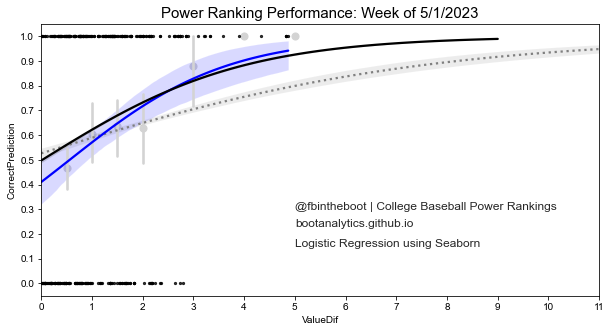

In [77]:
import seaborn as sns

#modelperformance = gamesWithRanks[['date', 'rank_date_x','Value_x', 'Value_y','Win','PredWin','CorrectPrediction']].dropna()\
#.assign(ValueDif = lambda x: (x['Value_x']-x['Value_y']))\
#.groupby(by=['rank_date_x','ValueDif'], as_index=False)['CorrectPrediction'].agg(['mean','count'])\
#.query("rank_date_x == '03/27/2023'").query("ValueDif >=.05").reset_index()


plotperformance = gamesWithRanks[['date', 'rank_date_x','Value_x', 'Value_y','Win','PredWin','CorrectPrediction']].dropna()\
.assign(ValueDif = lambda x: (x['Value_x']-x['Value_y']))\
.query("rank_date_x == '05/22/2023'").query("ValueDif >=.00")

seasonperformance = gamesWithRanks[['date', 'rank_date_x','Value_x', 'Value_y','Win','PredWin','CorrectPrediction']].dropna()\
.assign(ValueDif = lambda x: (x['Value_x']-x['Value_y']))\
.query("ValueDif >=.00")

#ax_mp = modelperformance.plot.scatter(x='ValueDif',y='mean')
#modelperformance.plot.line(x='ValueDif',y='mean', ax=ax_mp)

fig_pm, ax_pm = plt.subplots(figsize=(10,5))

sns.set()
sns.regplot(plotperformance['ValueDif'],plotperformance['CorrectPrediction'],x_bins=[.5,1,1.5,2,3,4,5,6,7,8,9,10] ,fit_reg=False, seed=100, ax=ax_pm, color='lightgrey')
sns.regplot(seasonperformance['ValueDif'],seasonperformance['CorrectPrediction'],scatter=False, logistic=True, seed=100, line_kws={'color':'grey','linestyle':'dotted'}, ax=ax_pm)
sns.regplot(plotperformance['ValueDif'],plotperformance['CorrectPrediction'], logistic=True, seed=100, line_kws={'color':'blue'},scatter_kws={'color':'black', 's':5}, ax=ax_pm)

sns.regplot([0,1,2,3,4,5,6,7,8,9], [0.5, 0.62, 0.73, 0.82, 0.88, 0.93, 0.96, 0.97, 0.98, 0.99] ,logistic=True,scatter=False,seed=100, line_kws={'color':'black'}, ax=ax_pm)

ax_pm.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax_pm.set_yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])

ax_pm.set_xlim([0,11])
#ax_pm.xlabel('Difference in Value')
ax_pm.set_title("Power Ranking Performance: Week of 5/1/2023", size=15, color='black')

ax_pm.annotate("@fbintheboot | College Baseball Power Rankings", (5,.3), size=12)
ax_pm.annotate("bootanalytics.github.io", (5,.23), size=12)

ax_pm.annotate("Logistic Regression using Seaborn", (5,.15), size=12)



In [78]:
predslist = []
for p in np.arange(0,10):
    print(p)
    predslist.append(results_sor.predict(p)[0].round(2))

0
1
2
3
4
5
6
7
8
9


In [79]:
predslist

[0.5, 0.62, 0.73, 0.82, 0.88, 0.93, 0.96, 0.97, 0.98, 0.99]

In [80]:
#gamesWithRanks[['date', 'rank_date_x','Value_x', 'Value_y','Win','PredWin','CorrectPrediction']].dropna()\
#.assign(ValueDif = lambda x: (x['Value_x']-x['Value_y']))\
#.assign(predict = )
#.query("rank_date_x == '03/06/2023'").query("ValueDif >=.00")


# Export Rankings

In [81]:
stats.to_csv("baseballrankings2023.csv")

# SOR EVALUATION

In [82]:
def soreval(df2):
    allgames = df2[['date', 'field', 'season_id', 'opponent_id', 'opponent_name','team','school_id','runs_scored','runs_allowed','result', 'game_id']].copy()
    allgames.loc[allgames['result']=='win', 'Win'] = 1
    allgames.loc[allgames['result']=='loss', 'Win'] = 0

    #WE NEED TO ADD THE DATE FILTER HERE TOO!!!
    allgames = pd.merge(allgames,powerrank(df2)[['Ranking', 'Value','school_id']],how='left',
             left_on='opponent_id', right_on='school_id')
    #allgames = allgames.merge(power4[['school_id','team']], how='left',left_on='school_id_x',right_on='school_id')

    allgames = allgames.assign(sos_value = lambda x: np.where(x['field']=='home', -.2283+x['Value'],np.where(x['field']=='away', .2283+x['Value'],0+x['Value'])))\
    .assign(baseline = lambda x: 2-x['sos_value'])

    sordf = pd.concat([allgames,results_sor.predict(allgames['baseline'])], axis=1).rename(columns={0: 'pred'})\
    .assign(sor = lambda x: x['Win']-x['pred'])
    #.groupby(by='team', as_index=False).mean().sort_values(by='sor', ascending=False)
    #.assign(sor_ratio = lambda x: x['Win']/x['pred']).head(40)

    #sordf['sor_rank'] = sordf['sor'].rank(ascending=False)
    return sordf

    


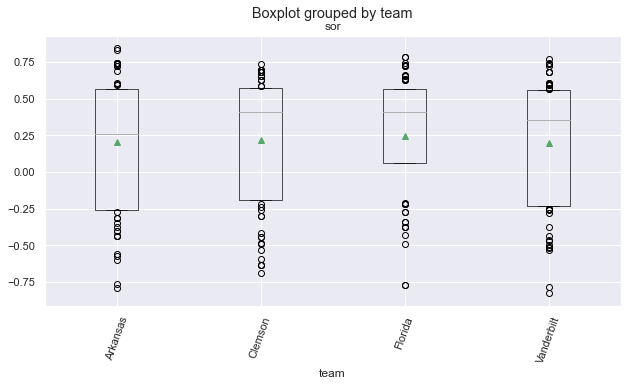

In [83]:
testteams = ['Wake Forest', 'Kentucky','Vanderbilt', 'Virginia','LSU']
testteams=['Arkansas','Clemson','Florida','Vanderbilt']
#testteams = list(t25.head(10)['ncaa_name'])
#soreval(expected).query(f"team.isin({testteams})").groupby('team').plot(x='pred', y='sor', kind='kde', subplots=True, xlim = (-1,1))
#soreval(expected).query(f"team.isin({testteams})").groupby('team').plot.kde(bw_method = 0.3)
#sor = Actual W/L - Expected(with Value of 2)

soreval(expected).query(f"team.isin({testteams})").boxplot(column='sor',by='team', showmeans=True, rot=70, figsize=(10,5), whis=0,widths=.3)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd877bbee80>,
      dtype=object)

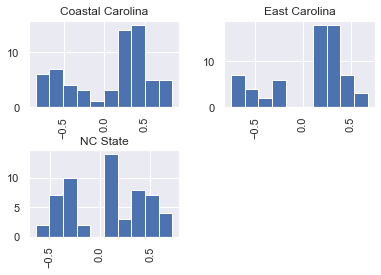

In [84]:
sorsubset = soreval(expected).query("team.isin(['NC State','East Carolina', 'Coastal Carolina'])")#.query("team=='Wake Forest'")
sorsubset['rolling']=sorsubset['sor'].expanding().mean()
#sorsubset/#.sort_values(by='r',ascending=True)\
sorsubset['sor'].hist(by=sorsubset['team'])#.groupby('team').hist('sor')

#soreval(expected)

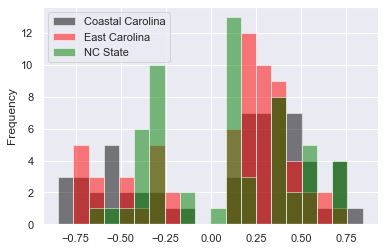

In [85]:
a = sorsubset[['team','sor']].pivot(columns='team', values='sor')#.hist()
b= [a[x].dropna().reset_index() for x in a.columns]
#pd.concat(b,axis=1)
pd.concat([b[0],b[1],b[2]],axis=1)[['Coastal Carolina','East Carolina','NC State']].plot.hist(alpha=.5,bins=20,color=['black','red','green'])

# SOS Breakdown

In [86]:
t50 = stats[(stats['rank_date']==stats['rank_date'].max()) & (stats['Overall Rank']<51)]
t50list = list(t50['ncaa_name'])

sos = soreval(expected)[['team','opponent_name','Value','Ranking','pred','sor']].groupby(by='team',as_index=False).mean()\
.sort_values(by='pred')

sos = sos[sos['team'].isin(t50list)][['team','pred','sor']]



from bokeh.plotting import figure, show
sosfig = figure(title='Strength of Schedule of Top 50 Teams [Boot Analytics @fbintheboot]',x_range=(.45,.8), y_range=((-0.05,.33)))

for t,sos,sor in sos.values.tolist():
    sosfig.image_url(url=[f'svgbaseballlogos/{t}.svg'], x=sos, y=sor, w=0.015, h=0.015)
    
#Top Left
sosfig.add_layout(Label(x=.47,y=.31,text=f"More Impressive Record", text_font_size='10px', text_color='green'))
sosfig.add_layout(Label(x=.47,y=.30,text=f"More Difficult Schedule", text_font_size='10px', text_color='green'))

#Bottom Left
sosfig.add_layout(Label(x=.47,y=-.03,text=f"More Difficult Schedule", text_font_size='10px', text_color='green'))
sosfig.add_layout(Label(x=.47,y=-.04,text=f"Less Impressive Record", text_font_size='10px', text_color='darkorange'))

#Bottom Right
sosfig.add_layout(Label(x=.72,y=-.03,text=f"Less Difficult Schedule", text_font_size='10px', text_color='darkorange'))
sosfig.add_layout(Label(x=.72,y=-.04,text=f"Less Impressive Record", text_font_size='10px', text_color='darkorange'))

#sosfig.add_layout(Label(x=.47,y=-.03,text=f"More Difficult Schedule", text_font_size='10px'))
#sosfig.add_layout(Label(x=.72,y=-.03,text=f"Less Difficult Schedule", text_font_size='10px'))


#sosfig.add_layout(Label(x=.47,y=-.04,text=f"Less Impressive Record", text_font_size='10px'))

#Axis Lables
sosfig.xaxis.axis_label = "STRENGTH OF SCHEDULE"
sosfig.yaxis.axis_label = "STRENGTH OF RECORD"

output_notebook()
show(sosfig)

Loading BokehJS ...

In [87]:
sos#.values.tolist()

0.7209952148536236

# Regional Breakdown

In [88]:
import random
import statsmodels as sm
four_predict = load_pickle("fourmetricspredict.pickle")

In [89]:
def gamesim(team1,team2):
    #if random.random() < results_sor.predict(regional_data[team1]-regional_data[team2]): #Prob #1 Seed Wins
    if random.random() < four_predict.predict([1]+regional_data[team1]+regional_data[team2]):
        winner = team1
        loser = team2
    else:
        winner = team2
        loser = team1
    return winner,loser

In [90]:


#calculate regional
def regional_sim(seed):
    regional_data = stats[(stats['rank_date'] == stats['rank_date'].max()) & stats['ncaa_name'].isin(list(seed.values()))]
    if len(regional_data) < 4:
        print(seed)
    
    regional_data = {d['ncaa_name']:[d['Eff_HV_4'],d['Expl_HV_4'],d['Eff_PV_4'],d['Expl_PV_4']] for n,d in regional_data.iterrows()}
    
    
    def gamesim(team1,team2):
        #if random.random() < results_sor.predict(regional_data[team1]-regional_data[team2]): #Prob #1 Seed Wins
        if random.random() < four_predict.predict([1]+regional_data[team1]+regional_data[team2]):
            winner = team1
            loser = team2
        else:
            winner = team2
            loser = team1
        return winner,loser

    regional_winners = {}
    regional_winners[seed[1]]=0
    regional_winners[seed[2]]=0
    regional_winners[seed[3]]=0
    regional_winners[seed[4]]=0

    regional_finals = {}
    regional_finals[seed[1]]=0
    regional_finals[seed[2]]=0
    regional_finals[seed[3]]=0
    regional_finals[seed[4]]=0

    #CREATE A LOOP TO SIMULATE OUTCOMES
    for x in np.arange(10000):
        winnersb = []
        losersb = []

        #Opening Round
        #1 vs 4
        w,l = gamesim(seed[1],seed[4])
        winnersb.append(w)
        losersb.append(l)

        #2 vs 3
        w,l = gamesim(seed[2],seed[3])
        winnersb.append(w)
        losersb.append(l)

        #Losers Bracket Game 1
        w,l = gamesim(losersb[0],losersb[1])
        #Loser is Eliminated, so losers bracket just holds this winner
        losersb=[w]

        #Winners Bracket Game 1
        w,l = gamesim(winnersb[0],winnersb[1])
        #Loser goes to losers bracket, winner stays in winners bracket
        winnersb=[w]
        losersb.append(l)

        #Losers Bracket Game 2
        w,l = gamesim(losersb[0],losersb[1])
        #Loser is Eliminated, so losers bracket just holds this winner
        losersb=[w]


        #One team in winners bracket, one team in losers bracket
        w,l = gamesim(winnersb[0],losersb[0])
        regional_finals[w]+=1
        regional_finals[l]+=1
        #IF NEEDED GAME
        if l == losersb[0]:
            #REGIONAL CHAMPION IS
            #print("Regional Champion is:" + w)
            regional_winners[w] +=1
        else:
            #Play Again
            w,l = gamesim(winnersb[0],losersb[0])
            #print("Regional Champion is:" + w)
            regional_winners[w] +=1
    
    return {k:v/10000 for (k,v) in regional_winners.items()},{k:v/10000 for (k,v) in regional_finals.items()}




In [91]:
#create list of seeds
seeds = [{1:'Wake Forest',2:'Maryland',3:'Kent St.',4:'Davidson'},
         {1:'LSU',2:'Texas',3:'Arizona St.',4:'Sam Houston St.'},
         {1:'Vanderbilt',2:'Oregon',3:'Iowa',4:'Maine'},
         {1:'Arkansas',2:'DBU',3:'Texas Tech',4:'Southeast Mo. St.'},
         {1:'Stanford',2:'Cal St. Fullerton',3:'Texas A&M',4:'LMU (CA)'},
         {1:'Duke',2:'Tennessee',3:'UNCW',4:'San Diego St.'},
         {1:'Kentucky',2:'Oregon St.',3:'Kansas St.',4:'Rider'},
         {1:'Florida',2:'Southern Miss.',3:'Southern California',4:'UIW'},
         {1:'West Virginia',2:'Virginia',3:'UTSA',4:'Wright St.'},
         {1:'South Carolina',2:'Indiana',3:'NC State',4:'Alabama St.'},
         {1:'Clemson',2:'Auburn',3:'UC Santa Barbara',4:'Army West Point'},
         {1:'Coastal Carolina',2:'East Carolina',3:'North Carolina',4:'Samford'},
         {1:'Miami (FL)',2:'Alabama',3:'Troy',4:'FGCU'},
         {1:'Oklahoma St.',2:'Indiana St.',3:'Texas St.',4:'Oral Roberts'},
         {1:'Boston College',2:'Northeastern',3:'Washington',4:'Harvard'},
         {1:'UConn',2:'Campbell',3:'Notre Dame',4:'Central Conn. St.'},
        ]

seeds = [{1:'Wake Forest',2:'Maryland',3:'Northeastern',4:'George Mason'},
         {1:'Florida',2:'UConn',3:'Texas Tech',4:'Florida A&M'},
         {1:'Arkansas',2:'TCU',3:'Arizona',4:'Santa Clara'},
         {1:'Clemson',2:'Tennessee',3:'Charlotte',4:'Lipscomb'},
         {1:'LSU',2:'Oregon St.',3:'Sam Houston St.',4:'Tulane'},
         {1:'Vanderbilt',2:'Oregon',3:'Xavier',4:'Eastern Ill.'},
         {1:'Virginia',2:'East Carolina',3:'Oklahoma',4:'Army West Point'},
         {1:'Stanford',2:'Texas A&M',3:'Cal St. Fullerton',4:'San Jose St.'},
          
         {1:'Miami (FL)',2:'Texas',3:'Louisiana',4:'Maine'},
         {1:'Coastal Carolina',2:'Duke',3:'UNCW',4:'Rider'},
         {1:'Oklahoma St.',2:'DBU',3:'Washington',4:'Oral Roberts'},
         {1:'Kentucky',2:'West Virginia',3:'Indiana',4:'Ball St.'},
         {1:'Auburn',2:'Southern Miss.',3:'Samford',4:'Penn'},
         {1:'Indiana St.',2:'Iowa',3:'North Carolina',4:'Wright St.'},
         {1:'South Carolina',2:'Campbell',3:'NC State',4:'Central Conn. St.'},
         {1:'Alabama',2:'Boston College',3:'Troy',4:'Nicholls St.'},
        ]


outcomes = []
for seed in seeds:
    outcomes.append(regional_sim(seed))

In [92]:
for r,o in enumerate(outcomes):
    print(r,o[0].values())
    
4%4

0 dict_values([0.9038, 0.0506, 0.0452, 0.0004])
1 dict_values([0.6304, 0.1015, 0.2659, 0.0022])
2 dict_values([0.3077, 0.3405, 0.217, 0.1348])
3 dict_values([0.286, 0.6187, 0.0612, 0.0341])
4 dict_values([0.8109, 0.1547, 0.03, 0.0044])
5 dict_values([0.6675, 0.1615, 0.1523, 0.0187])
6 dict_values([0.7343, 0.1803, 0.0743, 0.0111])
7 dict_values([0.4755, 0.4354, 0.064, 0.0251])
8 dict_values([0.6007, 0.3112, 0.0804, 0.0077])
9 dict_values([0.2528, 0.6835, 0.0527, 0.011])
10 dict_values([0.3141, 0.3674, 0.1673, 0.1512])
11 dict_values([0.6057, 0.3293, 0.0523, 0.0127])
12 dict_values([0.4347, 0.4309, 0.0485, 0.0859])
13 dict_values([0.2673, 0.2331, 0.4689, 0.0307])
14 dict_values([0.5901, 0.2192, 0.1884, 0.0023])
15 dict_values([0.7491, 0.1804, 0.0561, 0.0144])


0

In [93]:


regional_fig = figure(title='NCAA Baseball Regional Simulation [Boot Analytics @fbintheboot]',x_range=(0,30), y_range=(-.5,11.25), toolbar_location=None)
regional_fig.title.text_font_size="10px"

row = 13+1
column = 1
for r,o in enumerate(outcomes):
    column +=7.5
    #row-=3 #Vertical gap between each regional
    if r % 4 ==0:
        row-=3
        #column +=7.5 #Horizontal gap between each regional
        #row=11
        column=1
    rteams = o[0].keys() #Dictionary for Winning Regional
    win = o[0].values()
    finals = o[1].values() #Dictionary for being last 2
    
    for t,w,f,x,y in zip(rteams,win,finals,[0,3,0,3],[0,0,-1.25,-1.25]):
        regional_fig.image_url(url=[f'svgbaseballlogos/{t}.svg'], x=column+x, y=row+y+.25, w=1.2, h=1.2)
        regional_fig.add_layout(Label(x=column+x,y=row-.75+y,text=f"{t} ", text_font_size='6px'))
        regional_fig.add_layout(Label(x=column+x,y=row-1.05+y,text=f"{round(w*100,1)}% ", text_font_size='12px',text_font_style='bold',text_color='green' if w>0.5 else 'black'))
        regional_fig.add_layout(Label(x=column+x,y=row-1.25+y,text=f"{round(f*100,1)}% ", text_font_size='10px',text_color='green' if f>0.5 else 'black'))
    

regional_fig.add_layout(Label(x=.5,y=11,text="10,000 Simulations of each NCAA Baseball Regional using Team Value from bootanalytics.github.io", text_font_size='12px', text_font_style='italic'))
#regional_fig.add_layout(Label(x=.5,y=11,text="10,000 Simulations of each NCAA Baseball Regional using Team Value from bootanalytics.github.io", text_font_size='12px', text_font_style='italic'))

regional_fig.add_layout(Label(x=5.6,y=10,text="---> Win Regional", text_font_size='7px', text_font_style='italic'))
regional_fig.add_layout(Label(x=5.6,y=9.8,text="---> be in Final 2", text_font_size='7px', text_font_style='italic'))
    
    

regional_fig.xaxis.visible = False 
regional_fig.yaxis.visible = False 
regional_fig.xgrid.grid_line_color=None
regional_fig.ygrid.grid_line_color=None

output_notebook()
show(regional_fig)

Loading BokehJS ...

In [94]:
#SUPERREGIONAL SIMULATIONS
wr = [wr for wr,fg in outcomes]

col1=[]
col2=[]
col3=[]

for w,s in zip(wr,np.arange(1,17)):
    col1+=list(w.keys())
    col2+=list(w.values())
    col3+=[s for x in (1,2,3,4)]
    #print([c,a,b])

regs = pd.DataFrame({'Reg':col3,'Team':col1,'Win':col2})

In [95]:
regs

[1,16,2,15,3,14,4,13,5,12,6,11,7,10,8,9] #Regional Number
['Wake Forest','Alabama','Florida','South Carolina','TCU','Indiana St.','Tennessee','Southern Miss.',
'LSU','Kentucky','Oregon','Oral Roberts','Virginia','Duke','Stanford','Texas']#Regional Winners
[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

regs = pd.DataFrame({'Reg':[1,16,2,15,3,14,4,13,5,12,6,11,7,10,8,9],
                    'Team':['Wake Forest','Alabama','Florida','South Carolina','TCU','Indiana St.','Tennessee','Southern Miss.',
'LSU','Kentucky','Oregon','Oral Roberts','Virginia','Duke','Stanford','Texas'],
                    'Win':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]})

In [118]:
def supersim(team1,team2):
    t1win=0
    t2win=0
    regional_data = stats[(stats['rank_date'] == stats['rank_date'].max()) & stats['ncaa_name'].isin([team1,team2])]
    regional_data = {d['ncaa_name']:[d['Eff_HV_4'],d['Expl_HV_4'],d['Eff_PV_4'],d['Expl_PV_4']] for n,d in regional_data.iterrows()}
    
    #Let's Change it to the real format
    #Simulate 3 super regional games
    for x in np.arange(20000):
        g1 = int(random.random() < four_predict.predict([1]+regional_data[team1]+regional_data[team2])) #True (1) means Team1 wins, False (0) means Team2 wins
        g2 = int(random.random() < four_predict.predict([1]+regional_data[team1]+regional_data[team2]))
        g3 = int(random.random() < four_predict.predict([1]+regional_data[team1]+regional_data[team2]))
        if g1+g2+g3 >= 2:
            t1win+=1
        else:
            t2win+=1
    
    #for x in np.arange(10000):
    #    if random.random() < four_predict.predict([1]+regional_data[team1]+regional_data[team2]):
    #        t1win+=1
    #        
    #    else:
    #        t2win+=1
    return t1win/20000,t2win/20000

In [125]:
superwinners =[]
superprobs = []

#Loop through 8 Super Regional Pairings
for a,b in zip(np.arange(1,9),np.arange(9,17)[::-1]):
    #Loop through potential matchups
    for t in list(regs.query(f"Reg == {a}").Team):
        for o in list(regs.query(f"Reg == {b}").Team):
            sim = supersim(t,o)
            baseline = regs[regs['Team']==t]['Win'].iloc[0]*regs[regs['Team']==o]['Win'].iloc[0]
            #print(t,sim[0]*baseline,o,sim[1]*baseline)
            superwinners.append(t)
            superprobs.append(sim[0]*baseline)
            superwinners.append(o)
            superprobs.append(sim[1]*baseline)


In [141]:
omahabound = pd.DataFrame({'Team':superwinners,'SuperWin':superprobs}).groupby('Team').sum()\
.sort_values(by='SuperWin',ascending=False).reset_index()

In [142]:
omahabound

,Team,SuperWin
0,Tennessee,0.79715
1,Wake Forest,0.74770
2,LSU,0.69855
3,South Carolina,0.62620
4,TCU,0.60415
5,Virginia,0.59415
6,Texas,0.50670
7,Oregon,0.50165
8,Oral Roberts,0.49835
9,Stanford,0.49330


In [143]:


super_fig = figure(title='NCAA Baseball Omaha-Bound Simulation [Boot Analytics @fbintheboot]',x_range=(0,30), y_range=(-.5,11.25), toolbar_location=None)
super_fig.title.text_font_size="10px"


teamso = list(omahabound.Team)
win = list(omahabound.SuperWin)
row = 11
column = 2

for t,w in zip(teamso,win):
    super_fig.image_url(url=[f'svgbaseballlogos/{t}.svg'], x=column, y=row+.25, w=1.2, h=1.2)
    super_fig.add_layout(Label(x=column,y=row-.75,text=f"{t} ", text_font_size='6px'))
    super_fig.add_layout(Label(x=column,y=row-1.05,text=f"{round(w*100,1)}% ", text_font_size='12px',text_font_style='bold',text_color='green' if w>0.5 else 'black'))
    #super_fig.add_layout(Label(x=column+x,y=row-1.25+y,text=f"{round(f*100,1)}% ", text_font_size='10px',text_color='green' if f>0.5 else 'black'))
    column+=3.2
    if column > 26:
        row-=1.3
        column=2


    
super_fig.add_layout(Label(x=0,y=0,text="Probability team makes it to Omaha- Super Regionals using Boot Analytics Team Performance Rankings", text_font_size='10px'))
super_fig.add_layout(Label(x=5,y=-.25,text="Team Performance Rankings - bootanalytics.github.io", text_font_size='10px'))

super_fig.xaxis.visible = False 
super_fig.yaxis.visible = False 
super_fig.xgrid.grid_line_color=None
super_fig.ygrid.grid_line_color=None

output_notebook()
show(super_fig)

Loading BokehJS ...

In [100]:
omahabound

,Team,SuperWin
0,Tennessee,0.7105
1,Wake Forest,0.6684
2,LSU,0.6349
3,South Carolina,0.5822
4,TCU,0.5805
5,Virginia,0.5668
6,Oregon,0.5053
7,Texas,0.5039
8,Stanford,0.4961
9,Oral Roberts,0.4947
